In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\osann\anaconda3\envs\ethics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
ap_train = pd.read_csv(r'C:\Users\osann\Desktop\ETHICS\Project\application_train.csv',
                    usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")

Application train dataset shape: (307511, 26)


In [52]:
ap_train['AGE'] = -round(ap_train['DAYS_BIRTH']/365)
ap_train.drop(columns='DAYS_BIRTH', inplace=True)
ap_train['DAYS_EMPLOYED'].replace(365243, 0, inplace=True)

### Variables prone to ethical discussion

- CODE_GENDER
- CNT_CHILDREN
- NAME_TYPE_SUITE
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- REGION_POPULATION_RELATIVE
- DAYS_BIRTH
- DAYS_EMPLOYED
- DAYS_REGISTRATION (what is registration?)
- OWN_CAR_AGE
- FLAG_CONT_MOBILE
- OCCUPATION_TYPE
- CNT_FAM_MEMBERS
- REGION_RATING_CLIENT
- REGION_RATING_CLIENT_W_CITY
- ORGANIZATION_TYPE
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3 
- YEARS_BUILD_AVG
- YEARS_BUILD_MEDI
- HOUSETYPE_MODE
- WALLSMATERIAL_MODE
- EMERGENCYSTATE_MODE
- OBS_30_CNT_SOCIAL_CIRCLE
- DEF_30_CNT_SOCIAL_CIRCLE
- OBS_60_CNT_SOCIAL_CIRCLE
- DEF_60_CNT_SOCIAL_CIRCLE

### Cathegorical variables

- CODE_GENDER
- NAME_TYPE_SUITE
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- OCCUPATION_TYPE
- ORGANIZATION_TYPE
- HOUSETYPE_MODE
- WALLSMATERIAL_MODE
- EMERGENCYSTATE_MODE

### Numerical Variables with too many NaN

- OWN_CAR_AGE
- EXT_SOURCE_1
- EXT_SOURCE_3
- YEARS_BUILD_AVG
- YEARS_BUILD_MEDI

# **[#2] Interesting variables with respect to target**

### Relationship bewteen gender and target 

### Males

How many males are there in the dataset? How many how them has the target = 1?

In [4]:
count = 0
for i in range(len(ap_train)):
    if ap_train.CODE_GENDER[i]=='M':
        count +=1
print(count)

105059


In [5]:
count = 0
for i in range(len(ap_train)):
    if ap_train.TARGET[i] == 1 and ap_train.CODE_GENDER[i]=='M':
        count +=1
print(count)

10655


percetages of males with Target equal to 1

In [6]:
(10655/105059)*100

10.141920254333279

### Females

In [7]:
count = 0
for i in range(len(ap_train)):
    if ap_train.CODE_GENDER[i]=='F':
        count +=1
print(count)

202448


In [8]:
count = 0
for i in range(len(ap_train)):
    if ap_train.TARGET[i] == 1 and ap_train.CODE_GENDER[i]=='F':
        count +=1
print(count)

14170


percentages of female with Target equal to 1

In [9]:
(14170/202448)*100

6.999328222555916

### Name Type Suite

ap_train['NAME_TYPE_SUITE'].value_counts()

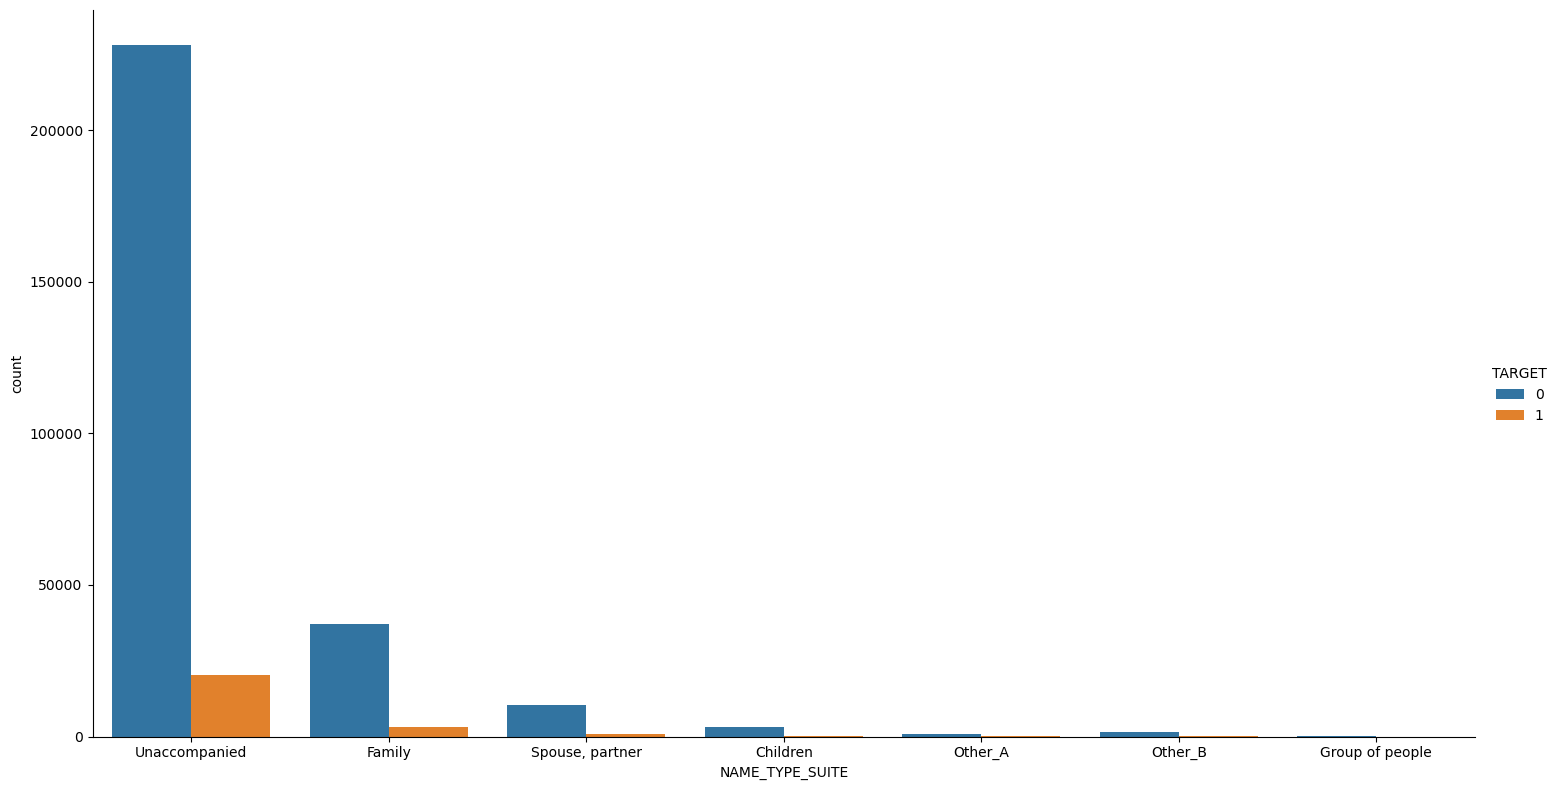

In [10]:
sns.catplot(x='NAME_TYPE_SUITE',hue='TARGET',data=ap_train,kind="count", height=8, aspect=15/8)

In [11]:
count_unaccompanied = 0
count_family = 0
count_spouse = 0
count_children = 0
count_B = 0
count_A = 0
count_group = 0
for i in range(len(ap_train)):
    if ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Unaccompanied':
        count_unaccompanied +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Family':
        count_family +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Spouse, partner':
        count_spouse +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Children':
        count_children +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Other_B':
        count_B +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Other_A':
        count_A +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_TYPE_SUITE[i]=='Group of people':
        count_group +=1
print(f"Unaccompanied with target = 1: {count_unaccompanied} \nFamily with target = 1: {count_family} \nSpouse, partner with target = 1: {count_spouse} \nChildren with target = 1: {count_children} \nOther_B with target = 1: {count_B} \nOther_A with target = 1: {count_A} \nGroup of people with target = 1: {count_group}")

Unaccompanied with target = 1: 20337 
Family with target = 1: 3009 
Spouse, partner with target = 1: 895 
Children with target = 1: 241 
Other_B with target = 1: 174 
Other_A with target = 1: 76 
Group of people with target = 1: 23


percetanges

In [12]:
print(f"Unaccompanied with target = 1: {(20337/248526)*100} \nFamily with target = 1: {(3009/40149)*100} \nSpouse, partner with target = 1: {(895/11370)*100} \nChildren with target = 1: {(241/3267)*100} \nOther_B with target = 1: {(174/1770)*100} \nOther_A with target = 1: {(76/866)*100} \nGroup of people with target = 1: {(23/271)*100}")

Unaccompanied with target = 1: 8.183047246565751 
Family with target = 1: 7.494582679518793 
Spouse, partner with target = 1: 7.871591908531222 
Children with target = 1: 7.376798285889195 
Other_B with target = 1: 9.830508474576272 
Other_A with target = 1: 8.775981524249422 
Group of people with target = 1: 8.487084870848708


### Income Type

In [13]:
ap_train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [14]:
count_working = 0
count_commercial = 0
count_pensioner = 0
count_state = 0
count_unemp = 0
count_student = 0
count_business = 0
count_maternity = 0
for i in range(len(ap_train)):
    if ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Working':
        count_working +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Commercial associate':
        count_commercial +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Pensioner':
        count_pensioner +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='State servant':
        count_state +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Unemployed':
        count_unemp +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Student':
        count_student +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Businessman':
        count_business +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_INCOME_TYPE[i]=='Maternity leave':
        count_maternity +=1
print(f"Working with target = 1: {count_working} \nCommercial associate with target = 1: {count_commercial} \nPensioner with target = 1: {count_pensioner} \nState servant with target = 1: {count_state} \nUnemployed with target = 1: {count_unemp} \nStudent with target = 1: {count_student} \nBusinessman with target = 1: {count_business} \nMaternity leave with target = 1: {count_maternity}")

Working with target = 1: 15224 
Commercial associate with target = 1: 5360 
Pensioner with target = 1: 2982 
State servant with target = 1: 1249 
Unemployed with target = 1: 8 
Student with target = 1: 0 
Businessman with target = 1: 0 
Maternity leave with target = 1: 2


percetages

In [15]:
print(f"Working with target = 1: {(15224/158774)*100} \nCommercial associate with target = 1: {(5360/71617)*100} \nPensioner with target = 1: {(2982/55362)*100} \nState servant with target = 1: {(1249/21703)*100} \nUnemployed with target = 1: {(8/22)*100} \nMaternity leave with target = 1: {(2/5)*100}")

Working with target = 1: 9.588471664126368 
Commercial associate with target = 1: 7.484256531270509 
Pensioner with target = 1: 5.386366099490625 
State servant with target = 1: 5.754964751416855 
Unemployed with target = 1: 36.36363636363637 
Maternity leave with target = 1: 40.0


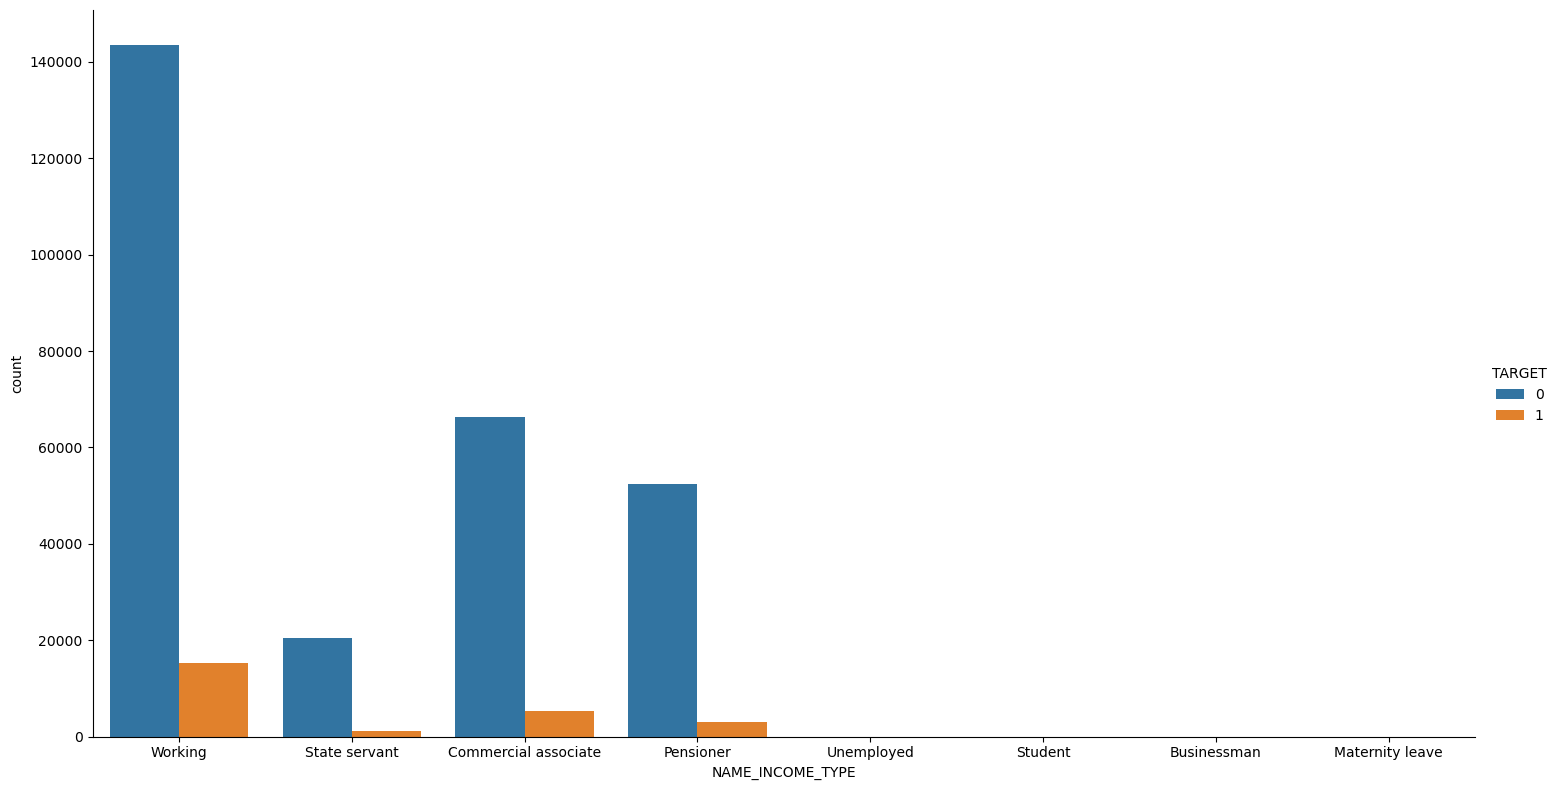

In [16]:
sns.catplot(x='NAME_INCOME_TYPE',hue='TARGET',data=ap_train,kind="count", height=8, aspect=15/8)

### Education Type

In [17]:
count_secondary = 0
count_higher = 0
count_spouse = 0
count_lower = 0
count_academic = 0

for i in range(len(ap_train)):
    if ap_train.TARGET[i] == 1 and ap_train.NAME_EDUCATION_TYPE[i]=='Secondary / secondary special':
        count_secondary +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_EDUCATION_TYPE[i]=='Higher education':
        count_higher +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_EDUCATION_TYPE[i]=='Incomplete higher':
        count_spouse +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_EDUCATION_TYPE[i]=='Lower secondary':
        count_lower +=1
    elif ap_train.TARGET[i] == 1 and ap_train.NAME_EDUCATION_TYPE[i]=='Academic degree':
        count_academic +=1

print(f"Secondary / secondary special with target = 1: {count_secondary} \nHigher education with target = 1: {count_higher} \nIncomplete higher with target = 1: {count_spouse} \nLower secondary with target = 1: {count_lower} \nAcademic degree with target = 1: {count_academic}")

Secondary / secondary special with target = 1: 19524 
Higher education with target = 1: 4009 
Incomplete higher with target = 1: 872 
Lower secondary with target = 1: 417 
Academic degree with target = 1: 3


percentages

In [18]:
print(f"Secondary / secondary special with target = 1: {(19524/218391)*100} \nHigher education with target = 1: {(4009/74863)*100} \nIncomplete higher with target = 1: {(872/10277)*100} \nLower secondary with target = 1: {(417/3816)*100} \nAcademic degree with target = 1: {(3/164)*100}")

Secondary / secondary special with target = 1: 8.939928843221562 
Higher education with target = 1: 5.355115344028425 
Incomplete higher with target = 1: 8.484966429891992 
Lower secondary with target = 1: 10.927672955974844 
Academic degree with target = 1: 1.8292682926829267


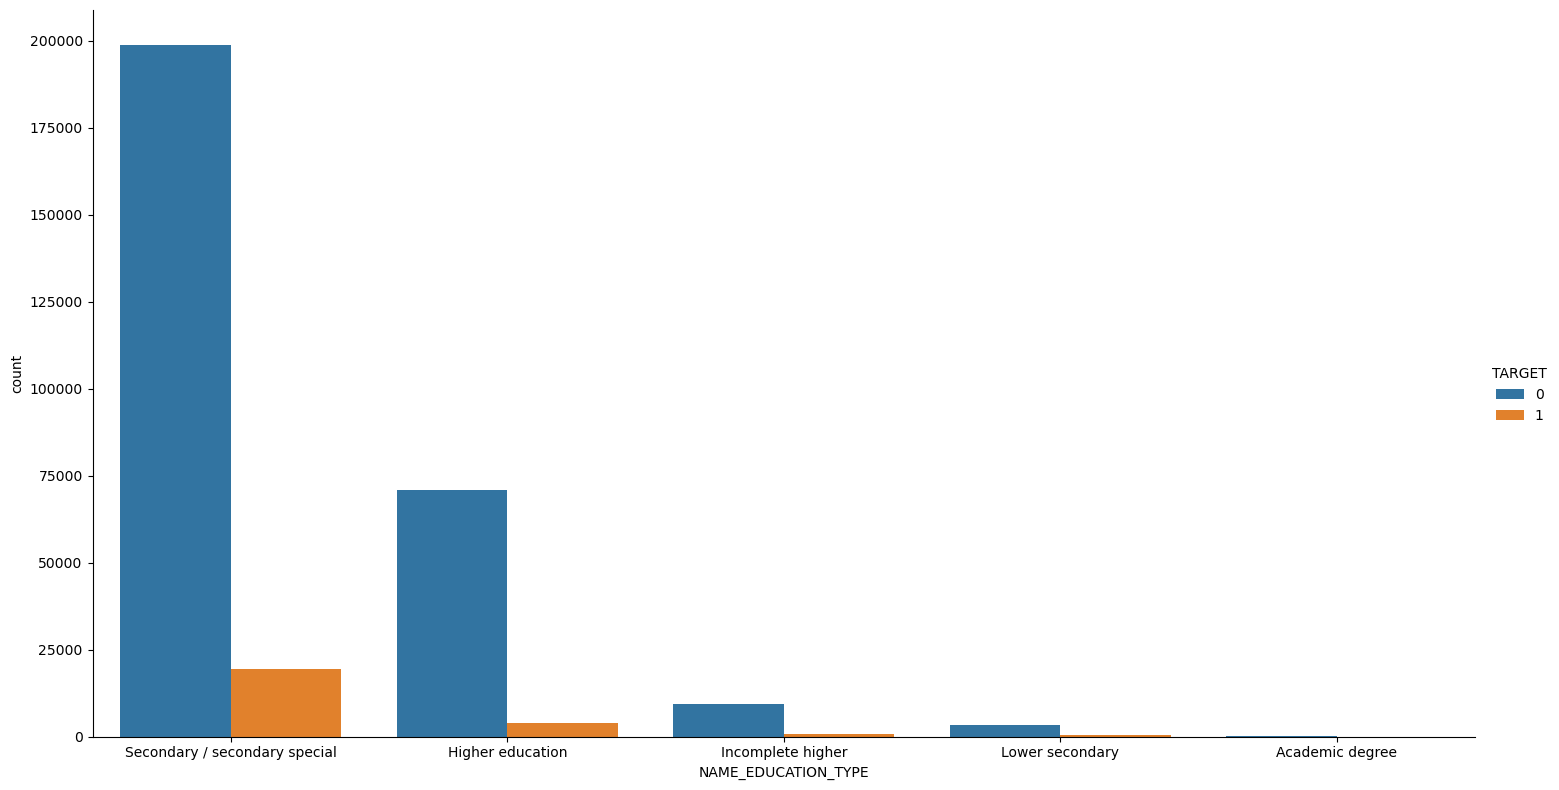

In [19]:
sns.catplot(x='NAME_EDUCATION_TYPE',hue='TARGET',data=ap_train,kind="count", height=8, aspect=15/8)

### Own Car Age Analysis

In [20]:
df_car = ap_train[['TARGET','OWN_CAR_AGE']]
df_car.isna().sum()
df_car.dropna(inplace=True)
df_car.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TARGET         0
OWN_CAR_AGE    0
dtype: int64

In [21]:
df_car.corr()

,TARGET,OWN_CAR_AGE
TARGET,1.000000,0.037612
OWN_CAR_AGE,0.037612,1.000000


In [22]:
print(f"The mean of OWN_CAR_AGE for TARGET = 1 is {round(df_car[df_car['TARGET'] == 1]['OWN_CAR_AGE'].mean(),2)} years")

The mean of OWN_CAR_AGE for TARGET = 1 is 13.67 years


In [23]:
print(f"The mean of OWN_CAR_AGE for TARGET = 0 is {round(df_car[df_car['TARGET'] == 0]['OWN_CAR_AGE'].mean(),2)} years")

The mean of OWN_CAR_AGE for TARGET = 0 is 11.94 years


### Ext_Source_1 Analysis

In [24]:
df_ext_1 = ap_train[['TARGET','EXT_SOURCE_1']]
df_ext_1.isna().sum()
df_ext_1.dropna(inplace=True)
df_ext_1.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TARGET          0
EXT_SOURCE_1    0
dtype: int64

In [25]:
df_ext_1.corr()

,TARGET,EXT_SOURCE_1
TARGET,1.000000,-0.155317
EXT_SOURCE_1,-0.155317,1.000000


In [26]:
print(f"The mean of EXT_SOURCE_1 for TARGET = 1 is {round(df_ext_1[df_ext_1['TARGET'] == 1]['EXT_SOURCE_1'].mean(),2)}")

The mean of EXT_SOURCE_1 for TARGET = 1 is 0.39


In [27]:
print(f"The mean of EXT_SOURCE_1 for TARGET = 0 is {round(df_ext_1[df_ext_1['TARGET'] == 0]['EXT_SOURCE_1'].mean(),2)}")

The mean of EXT_SOURCE_1 for TARGET = 0 is 0.51


### Ext_Source_3 Analysis

In [28]:
df_ext_3 = ap_train[['TARGET','EXT_SOURCE_3']]
df_ext_3.isna().sum()
df_ext_3.dropna(inplace=True)
df_ext_3.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TARGET          0
EXT_SOURCE_3    0
dtype: int64

In [29]:
df_ext_3.corr()

,TARGET,EXT_SOURCE_3
TARGET,1.000000,-0.178919
EXT_SOURCE_3,-0.178919,1.000000


In [30]:
print(f"The mean of EXT_SOURCE_3 for TARGET = 1 is {round(df_ext_3[df_ext_3['TARGET'] == 1]['EXT_SOURCE_3'].mean(),2)}")

The mean of EXT_SOURCE_3 for TARGET = 1 is 0.39


In [31]:
print(f"The mean of EXT_SOURCE_1 for TARGET = 0 is {round(df_ext_3[df_ext_3['TARGET'] == 0]['EXT_SOURCE_3'].mean(),2)}")

The mean of EXT_SOURCE_1 for TARGET = 0 is 0.52


### Count Children

<AxesSubplot:>

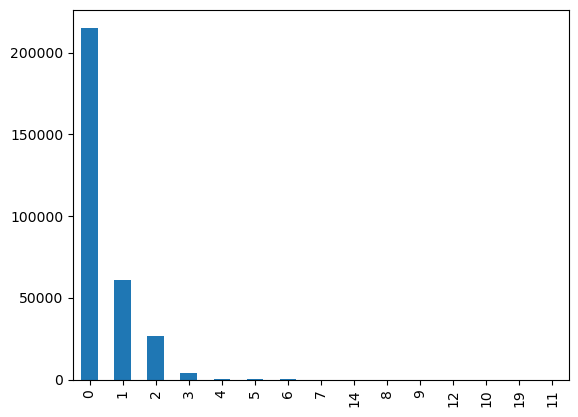

In [32]:
ap_train.CNT_CHILDREN.value_counts().plot(kind="bar")

In [33]:
#ap_train['TARGET'] = ap_train.index

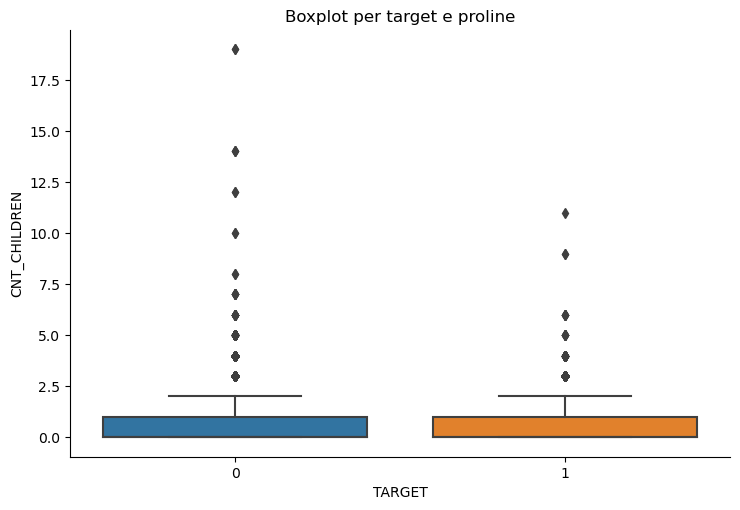

In [65]:
sns.catplot(x="TARGET", y="CNT_CHILDREN", data=ap_train, kind="box", aspect=1.5)
plt.title("Boxplot per target e proline")
plt.show()

In [35]:
int_children_freq = pd.crosstab(index=ap_train['CNT_CHILDREN'], 
                              columns=ap_train['TARGET'])

int_children_freq

TARGET,0,1
CNT_CHILDREN,,
0,198762,16609
1,55665,5454
2,24416,2333
3,3359,358
4,374,55
5,77,7
6,15,6
7,7,0
8,2,0


In [36]:
pd.crosstab(index=ap_train['CNT_CHILDREN'], 
            columns=ap_train['TARGET'],
            margins=True,
            normalize='all')

TARGET,0,1,All
CNT_CHILDREN,,,
0,0.646357,0.054011,0.700368
1,0.181018,0.017736,0.198754
2,0.079399,0.007587,0.086986
3,0.010923,0.001164,0.012087
4,0.001216,0.000179,0.001395
5,0.000250,0.000023,0.000273
6,0.000049,0.000020,0.000068
7,0.000023,0.000000,0.000023
8,0.000007,0.000000,0.000007


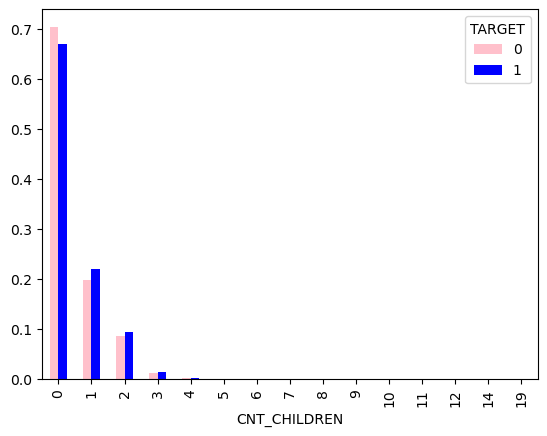

In [50]:
pd.crosstab(index=ap_train['CNT_CHILDREN'],
            columns=[ap_train['TARGET']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=False)
plt.show()

### Name Family Status

In [38]:
ap_train.NAME_FAMILY_STATUS.value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [39]:
int_status_freq = pd.crosstab(index=ap_train['NAME_FAMILY_STATUS'], 
                              columns=ap_train['TARGET'])

int_status_freq

TARGET,0,1
NAME_FAMILY_STATUS,,
Civil marriage,26814,2961
Married,181582,14850
Separated,18150,1620
Single / not married,40987,4457
Unknown,2,0
Widow,15151,937


In [20]:
int_status_perc = pd.crosstab(index=ap_train['NAME_FAMILY_STATUS'], 
                              columns=ap_train['TARGET']).apply(lambda r: r/r.sum(), axis=1)

int_status_perc

TARGET,0,1
NAME_FAMILY_STATUS,,
Civil marriage,0.900554,0.099446
Married,0.924401,0.075599
Separated,0.918058,0.081942
Single / not married,0.901923,0.098077
Unknown,1.000000,0.000000
Widow,0.941758,0.058242


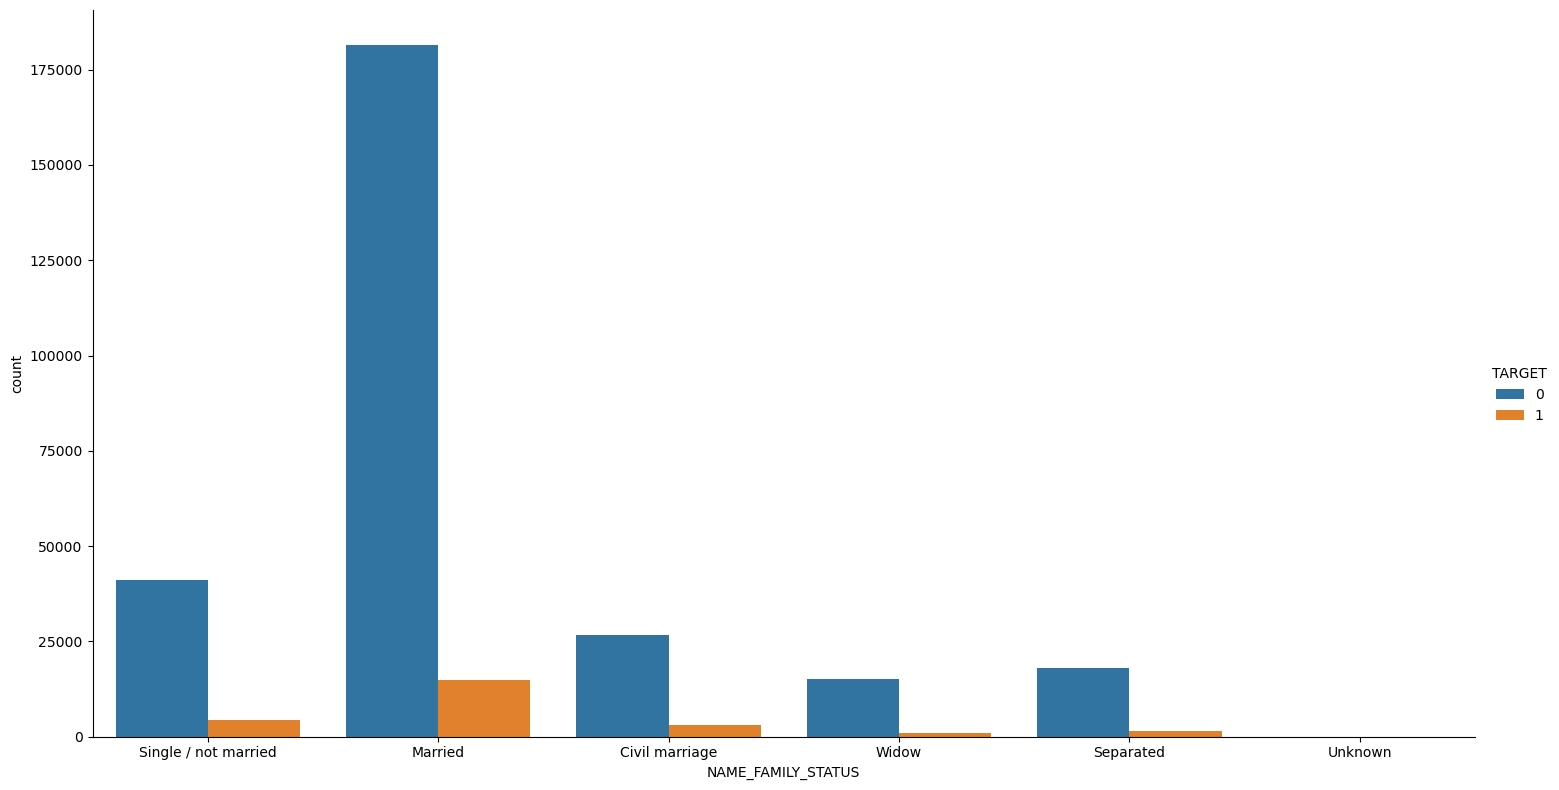

In [30]:
sns.catplot(x='NAME_FAMILY_STATUS',hue='TARGET',data=ap_train,kind="count", height=8, aspect=15/8)

### Housing Type

In [42]:
ap_train.NAME_HOUSING_TYPE.value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

In [43]:
int_housing_freq = pd.crosstab(index=ap_train['NAME_HOUSING_TYPE'], 
                              columns=ap_train['TARGET'])

int_housing_freq

TARGET,0,1
NAME_HOUSING_TYPE,,
Co-op apartment,1033,89
House / apartment,251596,21272
Municipal apartment,10228,955
Office apartment,2445,172
Rented apartment,4280,601
With parents,13104,1736


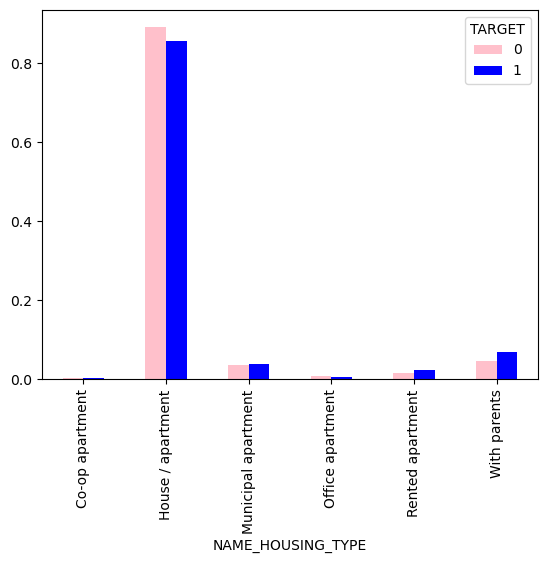

In [26]:
pd.crosstab(index=ap_train['NAME_HOUSING_TYPE'],
            columns=[ap_train['TARGET']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=False)
plt.show()

### Region Population

In [45]:
ap_train.REGION_POPULATION_RELATIVE.mean()

0.020868112057780035

<AxesSubplot:xlabel='TARGET', ylabel='REGION_POPULATION_RELATIVE'>

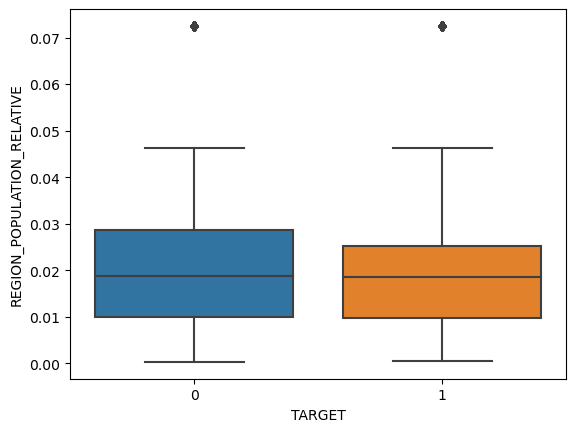

In [46]:
sns.boxplot(x = "TARGET", y = "REGION_POPULATION_RELATIVE", data = ap_train)

### Days Employed

In [47]:
ap_train.DAYS_EMPLOYED.mean()

-1954.8481225061869

### Days Registration

<AxesSubplot:xlabel='TARGET', ylabel='DAYS_REGISTRATION'>

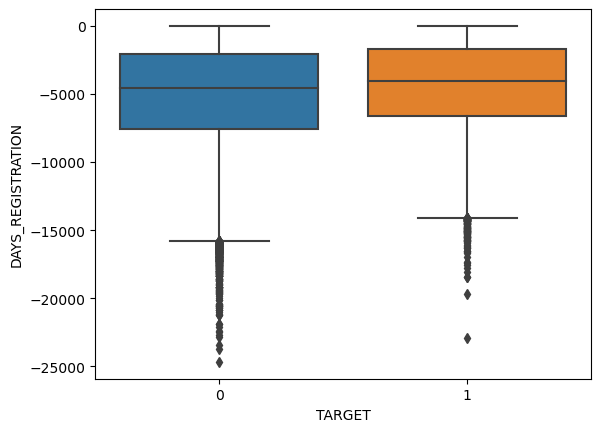

In [48]:
sns.boxplot(x = "TARGET", y = "DAYS_REGISTRATION", data = ap_train)

### Occupation Type

In [49]:
ap_train.OCCUPATION_TYPE.value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

int_occ_freq = pd.crosstab(index=ap_train['OCCUPATION_TYPE'], 
                              columns=ap_train['TARGET'])

int_occ_freq

In [50]:
int_occ_perc = pd.crosstab(index=ap_train['OCCUPATION_TYPE'], 
                              columns=ap_train['TARGET']).apply(lambda r: r/r.sum(), axis=1)


int_occ_perc

TARGET,0,1
OCCUPATION_TYPE,,
Accountants,0.951697,0.048303
Cleaning staff,0.903933,0.096067
Cooking staff,0.895560,0.104440
Core staff,0.936960,0.063040
Drivers,0.886739,0.113261
HR staff,0.936057,0.063943
High skill tech staff,0.938401,0.061599
IT staff,0.935361,0.064639
Laborers,0.894212,0.105788


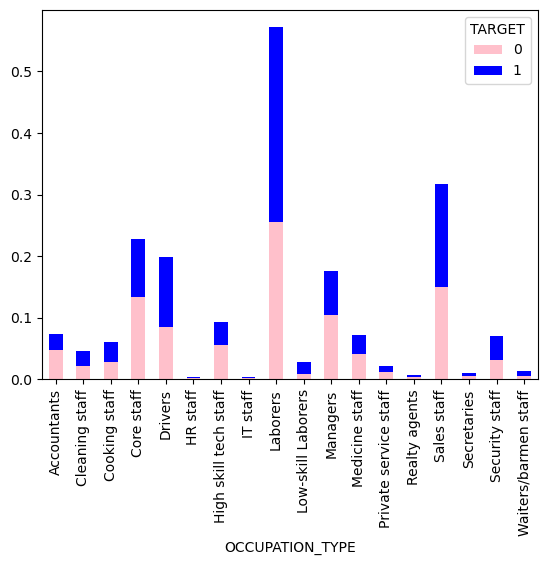

In [51]:
pd.crosstab(index=ap_train['OCCUPATION_TYPE'],
            columns=[ap_train['TARGET']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=True)
plt.show()

### Correlation matrix

### Numerical variables with few NaN

In [55]:
df = pd.read_csv('application_train.csv')

In [56]:
df_var = df[['TARGET',
'CNT_CHILDREN', 
'REGION_POPULATION_RELATIVE',
'DAYS_BIRTH',
'DAYS_EMPLOYED',
'DAYS_REGISTRATION',
'FLAG_CONT_MOBILE',
'CNT_FAM_MEMBERS',
'REGION_RATING_CLIENT',
'REGION_RATING_CLIENT_W_CITY',
'EXT_SOURCE_2',
'OBS_30_CNT_SOCIAL_CIRCLE',
'DEF_30_CNT_SOCIAL_CIRCLE',
'OBS_60_CNT_SOCIAL_CIRCLE',
'DEF_60_CNT_SOCIAL_CIRCLE']]

In [57]:
df_var['CNT_FAM_MEMBERS'] = df_var['CNT_FAM_MEMBERS'].fillna(np.mean(df_var['CNT_FAM_MEMBERS']))
df_var['EXT_SOURCE_2'] = df_var['EXT_SOURCE_2'].fillna(np.mean(df_var['EXT_SOURCE_2']))

df_var = df_var.dropna()
df_var.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TARGET                         0
CNT_CHILDREN                   0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
FLAG_CONT_MOBILE               0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
EXT_SOURCE_2                   0
OBS_30_CNT_SOCIAL_CIRCLE       0
DEF_30_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
dtype: int64

<AxesSubplot:>

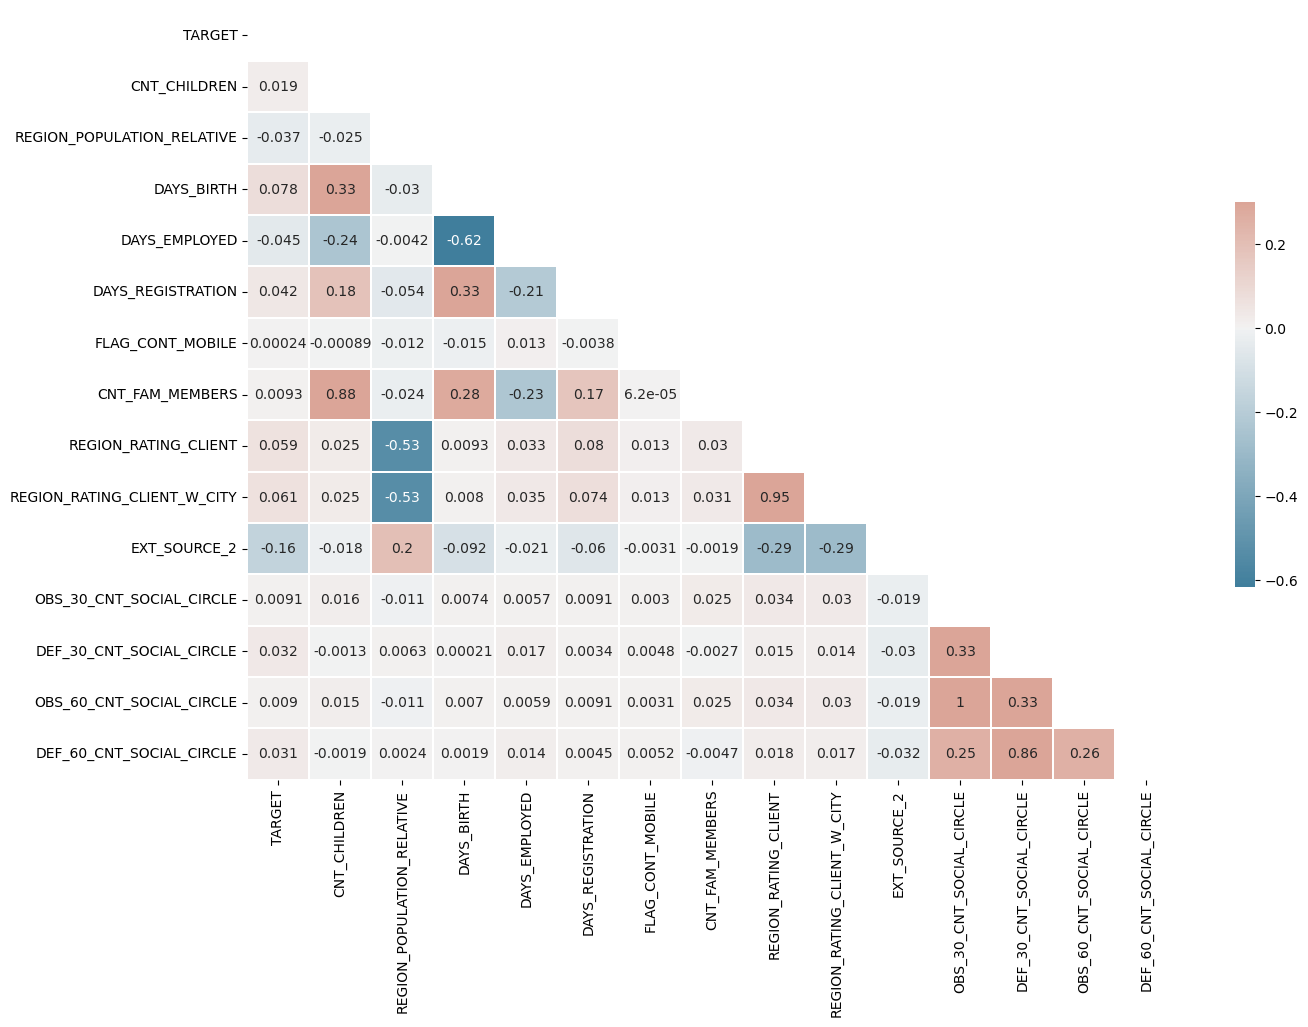

In [58]:
corr = df_var.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=False, linewidths=0.1, cbar_kws={"shrink": .5}, annot = True)

# Preparing the Data

Let's prepare the data for a simple ML model.

First of all, feature encoding.

In [34]:
ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train.drop(columns='CODE_GENDER', inplace=True)

In [35]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

Let's separate the target from the rest of the data

In [36]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Target dataset shape: (307511,)


Let's split the original dataset in two:

*   80% for the train dataset
*   20% for the test one

In [37]:
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (246008, 25)
Test dataset shape: (61503, 25)


# Create a basic ML model and scoring on the test set

I'll train a simple XGBoost model (parameters previously chosen with cross-validation).  

In [38]:
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)

Let's score the test set.

In [39]:
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [40]:
xgb_base_test_results[:5]

array([0.41913784, 0.29530373, 0.76142585, 0.23595197, 0.5197317 ],
      dtype=float32)

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
metrics.auc(fpr, tpr)

0.7534904346699134

In [42]:
results = xgb_base_test_results.tolist()
df_test['results'] = results


The third customer has a higher risk score (0.796) than the others in the first 5 records.

This simple model has an AUC on the test set around **0.754**, a decent baseline performance.

# **[#3] Evaluating feature importance**

In [ ]:
#plot the ROC curve
fig = px.line(x=fpr, y=tpr, title='ROC Curve', width=500,height=500,)
fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1, line=dict(color="Red", dash="dash"))
fig.show()

In [24]:
ap_train4 = pd.read_csv('application_train.csv',
usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])

In [25]:
ap_train4['AGE'] = -round(ap_train4['DAYS_BIRTH']/365)
ap_train4.drop(columns='DAYS_BIRTH', inplace=True)

In [26]:
ap_train4['CODE_GENDER_M'] = np.select([ap_train4['CODE_GENDER'] == 'M', ap_train4['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train4['FLAG_OWN_CAR'] = np.where(ap_train4['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train4['FLAG_OWN_REALTY'] = np.where(ap_train4['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train4.drop(columns='CODE_GENDER', inplace=True)

In [27]:
pd.set_option('display.max_columns', None)
#ap_train transform categorical variables into dummies
ap_train4 = pd.get_dummies(ap_train4, columns=ap_objects, drop_first=True)

In [28]:
import xgboost
import shap

# train an XGBoost model
#create a train and test set
X_train, X_test, y_train, y_test = train_test_split(ap_train4.drop(columns=['TARGET', 'SK_ID_CURR']), ap_train4['TARGET'], test_size=0.2, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

In [29]:
explainer_test = shap.Explainer(model.predict, X_test)
shap_values_test = explainer_test(X_test)

Permutation explainer: 61504it [5:05:30,  3.35it/s]                                  


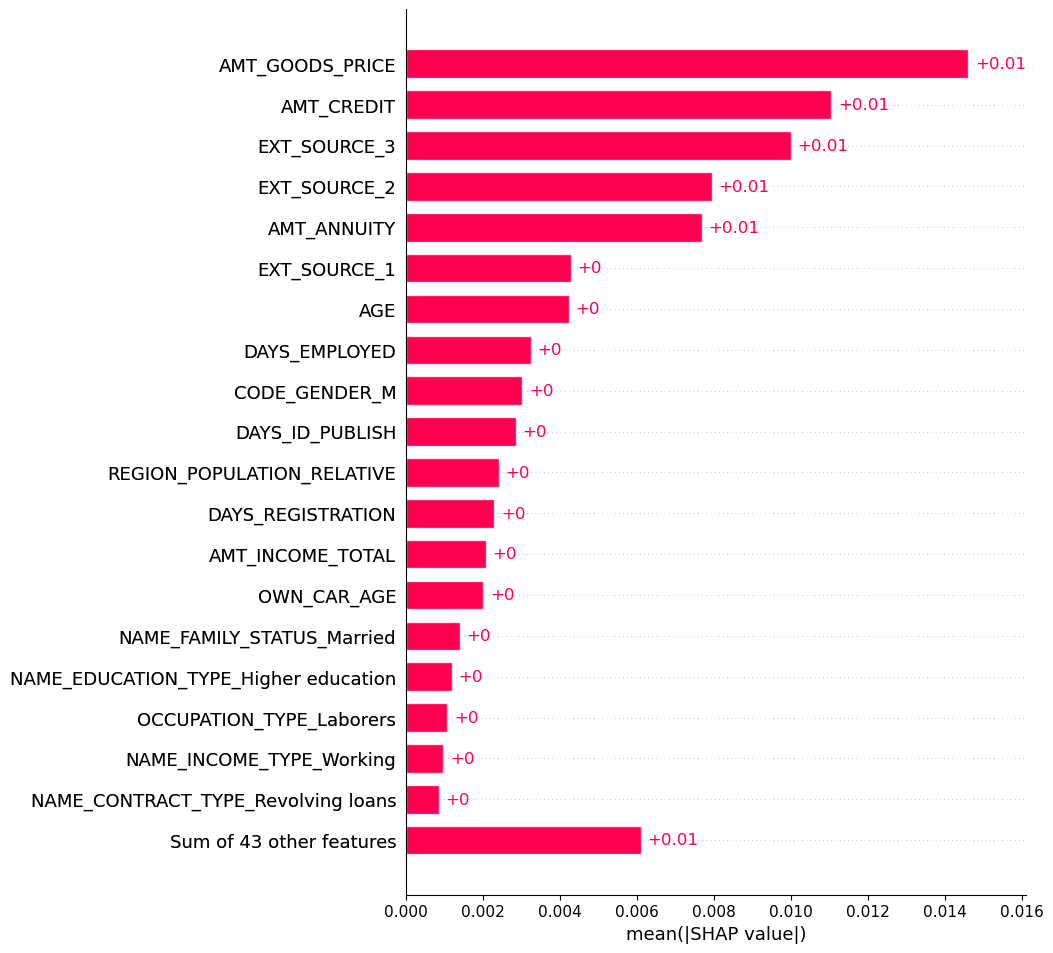

In [31]:
shap.plots.bar(shap_values_test, max_display= 20)

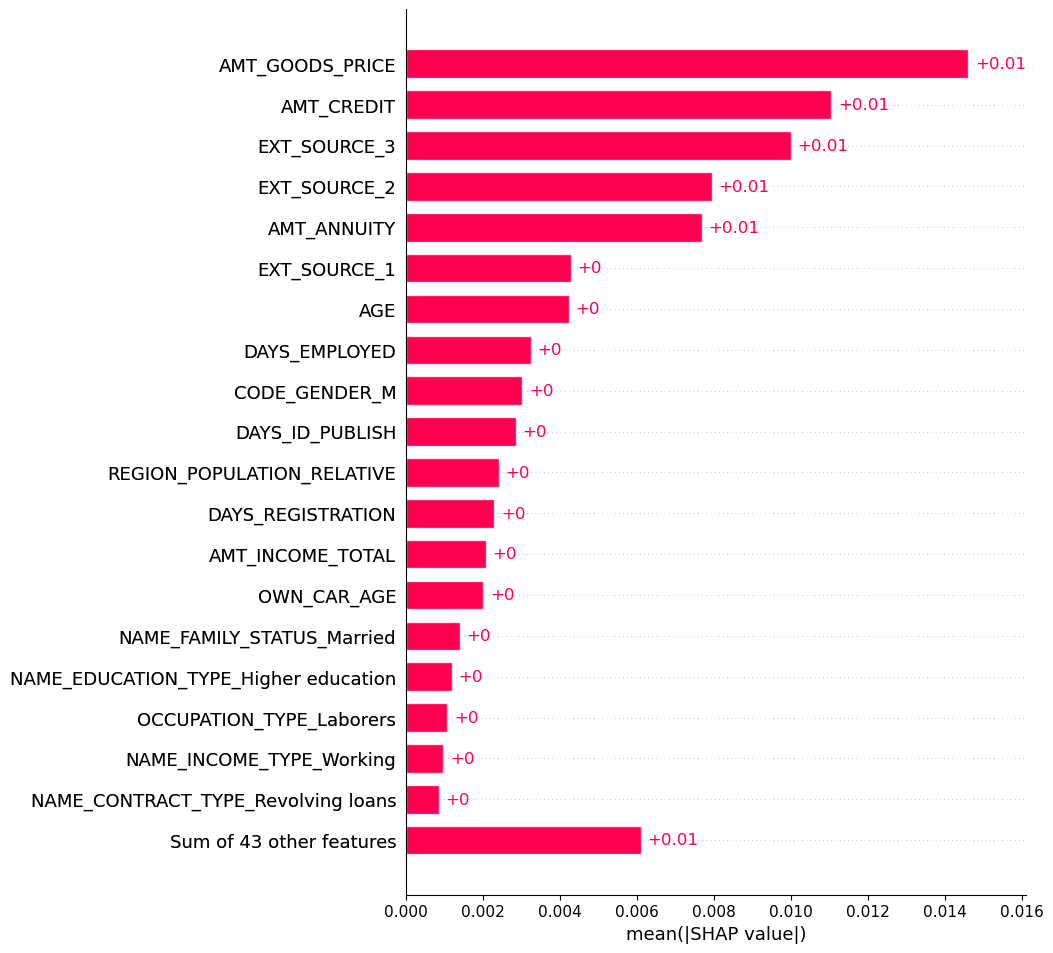

In [32]:
shap.plots.bar(shap_values_test, max_display= 20)

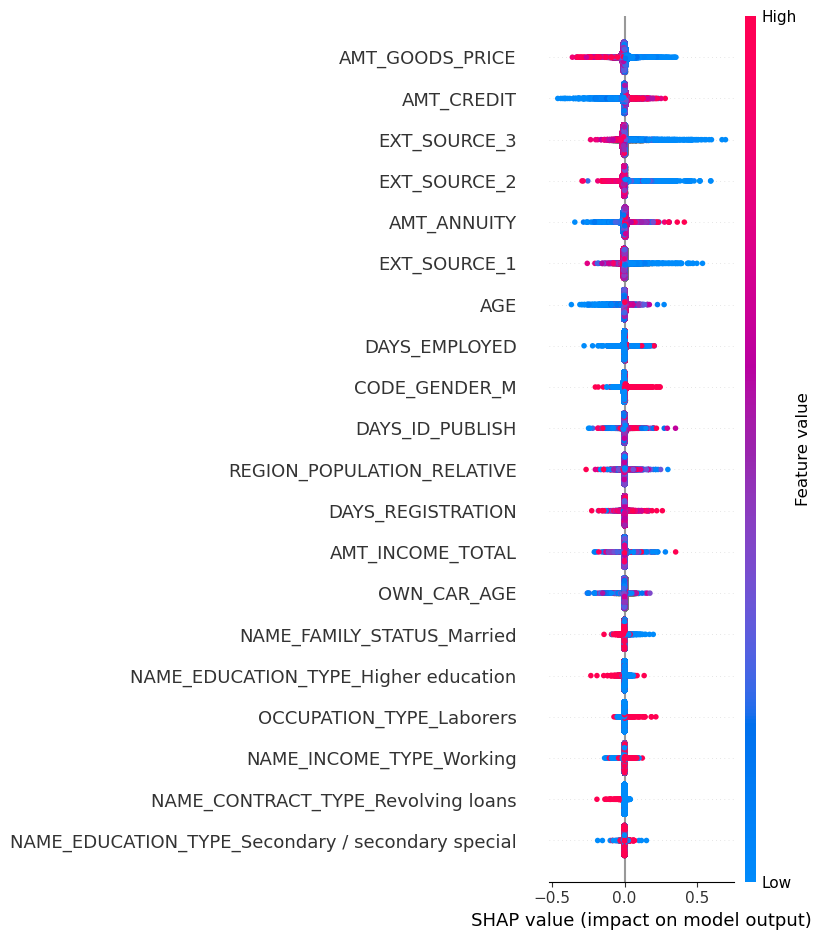

In [33]:
shap.summary_plot(shap_values_test, max_display= 20)

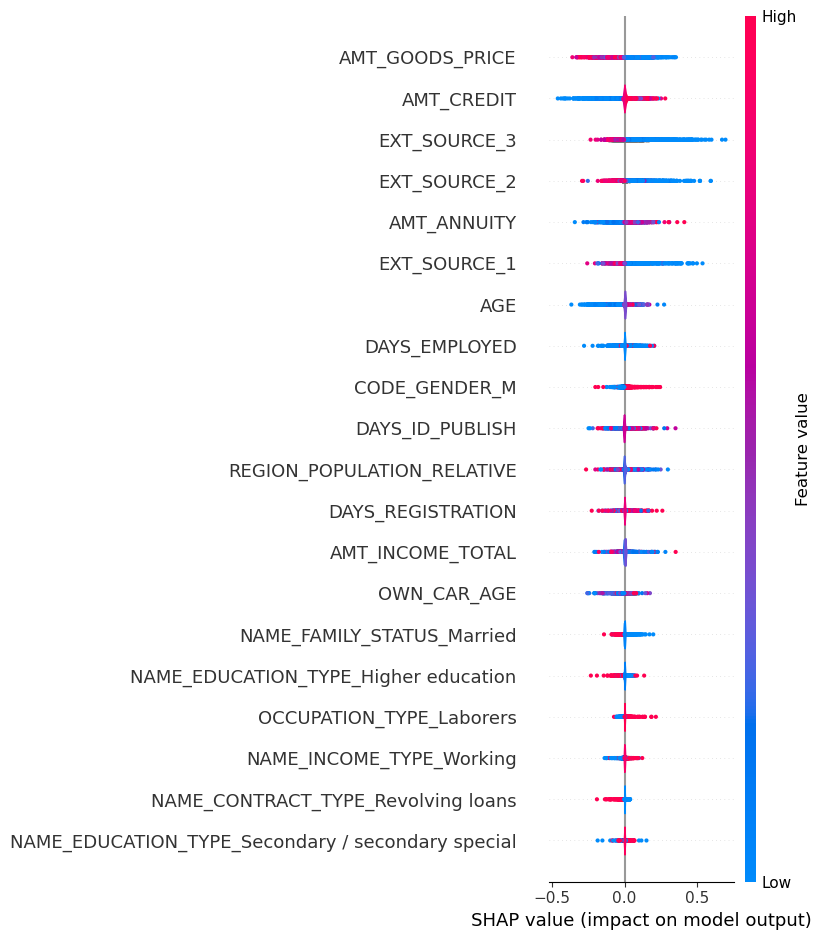

In [34]:
shap.summary_plot(shap_values_test, plot_type = 'violin')

In [69]:
#feature importance
xgb_base_model.get_score(importance_type='gain')

{'NAME_CONTRACT_TYPE': 114.93092346191406,
 'FLAG_OWN_CAR': 34.36250305175781,
 'FLAG_OWN_REALTY': 32.12001037597656,
 'CNT_CHILDREN': 27.065536499023438,
 'AMT_INCOME_TOTAL': 41.18702697753906,
 'AMT_CREDIT': 83.34734344482422,
 'AMT_ANNUITY': 66.66471099853516,
 'AMT_GOODS_PRICE': 72.46806335449219,
 'NAME_TYPE_SUITE': 33.83327865600586,
 'NAME_INCOME_TYPE': 108.46736145019531,
 'NAME_EDUCATION_TYPE': 167.6863555908203,
 'NAME_FAMILY_STATUS': 49.54628372192383,
 'NAME_HOUSING_TYPE': 33.516563415527344,
 'REGION_POPULATION_RELATIVE': 41.53240203857422,
 'DAYS_EMPLOYED': 77.28215026855469,
 'DAYS_REGISTRATION': 40.848609924316406,
 'DAYS_ID_PUBLISH': 48.189170837402344,
 'OWN_CAR_AGE': 76.79167938232422,
 'OCCUPATION_TYPE': 56.85335159301758,
 'EXT_SOURCE_1': 107.09048461914062,
 'EXT_SOURCE_2': 284.8829345703125,
 'EXT_SOURCE_3': 365.5814208984375,
 'AGE': 82.6365737915039,
 'CODE_GENDER_M': 185.7347869873047}

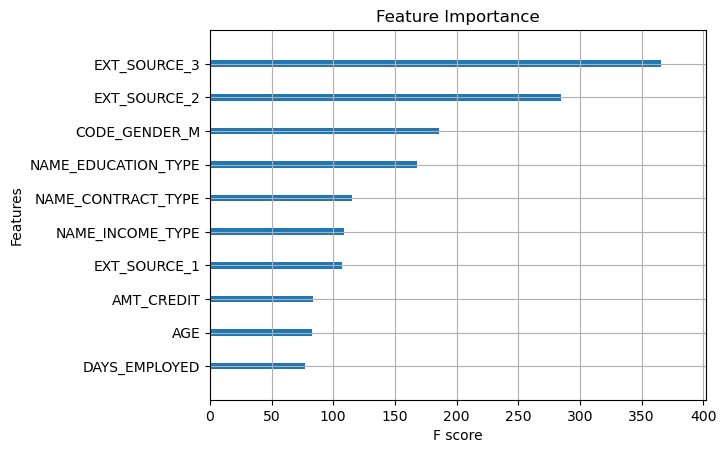

In [70]:
#plot feature importance
xgb.plot_importance(xgb_base_model, importance_type='gain', max_num_features=10, show_values=False, title='Feature Importance')
plt.show()


# **[#4] Comparing the model predictions with respect to the original training data**

In [43]:
list_results = xgb_base_test_results.tolist()
test = df_test
test['results'] = list_results
test['Target_results'] = np.where(test['results'] > 0.5, '1', '0')

In [44]:
int_children_freq = pd.crosstab(index=test['CNT_CHILDREN'], 
                              columns=test['Target_results'])

int_children_freq

Target_results,0,1
CNT_CHILDREN,,
0,32060,11079
1,8214,3799
2,3632,1813
3,481,300
4,68,36
5,7,8
6,2,0
12,1,0
14,1,1


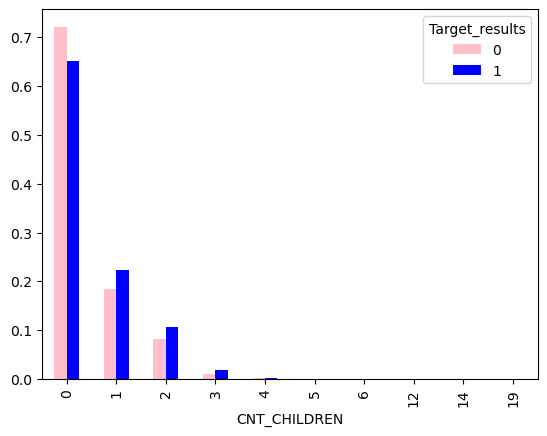

In [45]:
pd.crosstab(index=test['CNT_CHILDREN'],
            columns=[test['Target_results']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=False)
plt.show()

In [46]:
int_status_freq = pd.crosstab(index=test['NAME_FAMILY_STATUS'], 
                              columns=test['Target_results'])

int_status_freq

Target_results,0,1
NAME_FAMILY_STATUS,,
Civil marriage,3911,2052
Married,29030,10249
Separated,2905,1025
Single / not married,5928,3157
Widow,2692,554


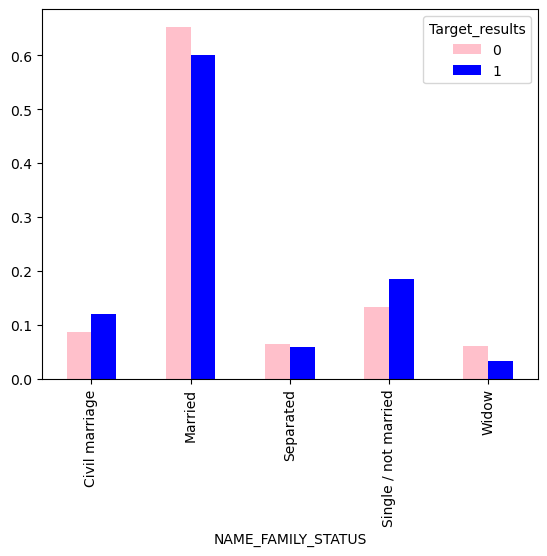

In [47]:
pd.crosstab(index=test['NAME_FAMILY_STATUS'],
            columns=[test['Target_results']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=False)
plt.show()

In [40]:
int_housing_freq = pd.crosstab(index=test['NAME_HOUSING_TYPE'], 
                              columns=test['Target_results'])

int_housing_freq

Target_results,0,1
NAME_HOUSING_TYPE,,
Co-op apartment,183,57
House / apartment,40094,14391
Municipal apartment,1659,608
Office apartment,377,143
Rented apartment,525,483
With parents,1628,1355


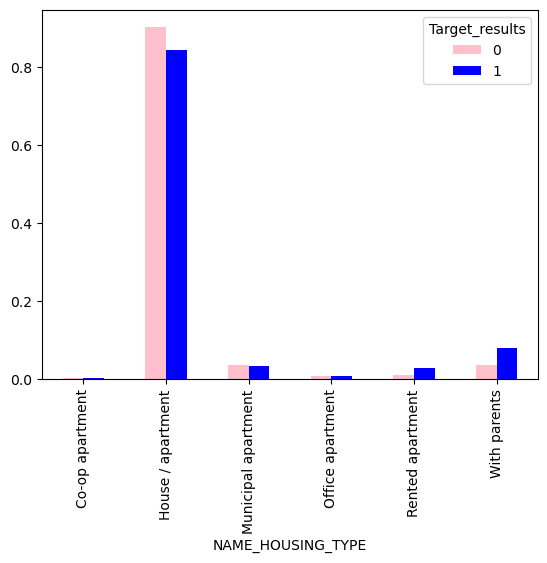

In [48]:
pd.crosstab(index=test['NAME_HOUSING_TYPE'],
            columns=[test['Target_results']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=False)
plt.show()

<AxesSubplot:xlabel='Target_results', ylabel='REGION_POPULATION_RELATIVE'>

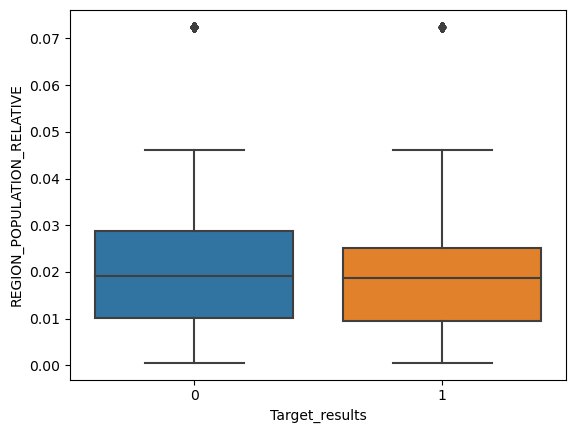

In [42]:
sns.boxplot(x = "Target_results", y = "REGION_POPULATION_RELATIVE", data = test)

<AxesSubplot:xlabel='Target_results', ylabel='DAYS_REGISTRATION'>

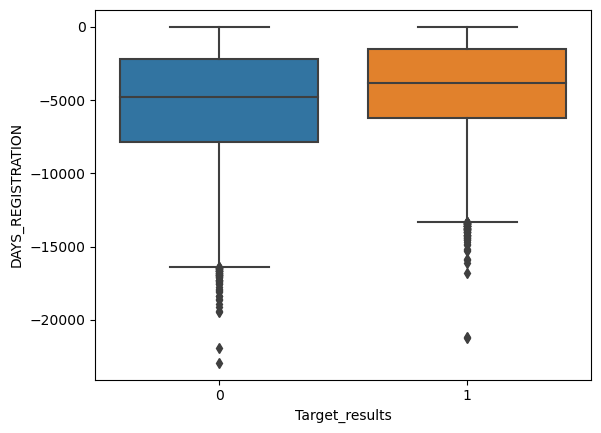

In [43]:
sns.boxplot(x = "Target_results", y = "DAYS_REGISTRATION", data = test)

In [44]:
int_occ_freq = pd.crosstab(index=test['OCCUPATION_TYPE'], 
                              columns=test['Target_results'])

int_occ_freq

Target_results,0,1
OCCUPATION_TYPE,,
Accountants,1679,252
Cleaning staff,653,259
Cooking staff,753,426
Core staff,4304,1173
Drivers,2087,1572
HR staff,102,18
High skill tech staff,1775,512
IT staff,71,31
Laborers,6636,4291


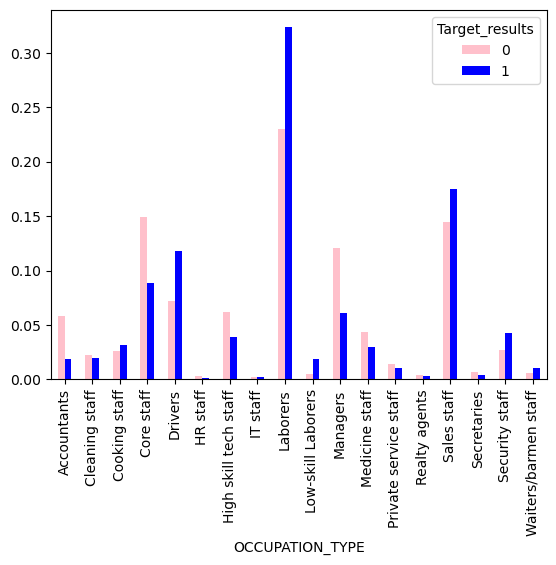

In [49]:
pd.crosstab(index=test['OCCUPATION_TYPE'],
            columns=[test['Target_results']],
            normalize='columns').plot.bar(color=['pink', 'blue'], stacked=False)
plt.show()

<AxesSubplot:xlabel='Target_results', ylabel='EXT_SOURCE_2'>

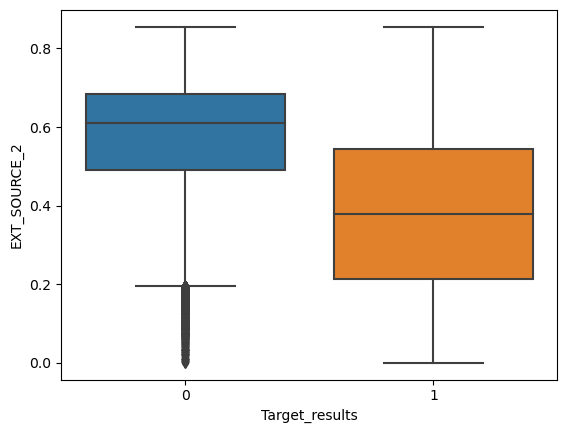

In [46]:
sns.boxplot(x = "Target_results", y = "EXT_SOURCE_2", data = test)

### Gender Analysis

Males

In [47]:
test = test.dropna(subset=['CODE_GENDER_M'])
test['CODE_GENDER_M'] = test['CODE_GENDER_M'].astype(float)
test.reset_index(drop = True, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
count = 0
for i in range(len(test)):
    if test.CODE_GENDER_M[i]==1:
        count +=1
print(count)

20940


In [49]:
count = 0
for i in range(len(test)):
    if test.Target_results[i] == '1' and test.CODE_GENDER_M[i]==1:
        count +=1
print(count)

7889


% males with target = 1

In [50]:
(7889/20940)*100

37.67430754536772

before: 10.141920254333279

Females

In [51]:
count = 0
for i in range(len(test)):
    if test.CODE_GENDER_M[i]==0:
        count +=1
print(count)

40561


In [52]:
count = 0
for i in range(len(test)):
    if test.Target_results[i] == '1' and test.CODE_GENDER_M[i]==0:
        count +=1
print(count)

9147


In [53]:
(9147/40561)*100

22.55121915140159

before 6.999328222555916

### Name Type Suite

In [54]:
count_unaccompanied = 0
count_family = 0
count_spouse = 0
count_children = 0
count_B = 0
count_A = 0
count_group = 0
for i in range(len(test)):
    if test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Unaccompanied':
        count_unaccompanied +=1
    elif test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Family':
        count_family +=1
    elif test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Spouse, partner':
        count_spouse +=1
    elif test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Children':
        count_children +=1
    elif test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Other_B':
        count_B +=1
    elif test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Other_A':
        count_A +=1
    elif test.Target_results[i] == '1' and test.NAME_TYPE_SUITE[i]=='Group of people':
        count_group +=1
print(f"Unaccompanied with target = 1: {count_unaccompanied} \nFamily with target = 1: {count_family} \nSpouse, partner with target = 1: {count_spouse} \nChildren with target = 1: {count_children} \nOther_B with target = 1: {count_B} \nOther_A with target = 1: {count_A} \nGroup of people with target = 1: {count_group}")

Unaccompanied with target = 1: 13955 
Family with target = 1: 2009 
Spouse, partner with target = 1: 719 
Children with target = 1: 131 
Other_B with target = 1: 113 
Other_A with target = 1: 62 
Group of people with target = 1: 10


%

In [55]:
print(f"Unaccompanied with target = 1: {(13955/49716)*100} \nFamily with target = 1: {(2009/8069)*100} \nSpouse, partner with target = 1: {(719/2302)*100} \nChildren with target = 1: {(131/594)*100} \nOther_B with target = 1: {(113/338)*100} \nOther_A with target = 1: {(62/169)*100} \nGroup of people with target = 1: {(10/50)*100}")

Unaccompanied with target = 1: 28.069434387319976 
Family with target = 1: 24.897756847192962 
Spouse, partner with target = 1: 31.233709817549954 
Children with target = 1: 22.053872053872052 
Other_B with target = 1: 33.43195266272189 
Other_A with target = 1: 36.68639053254438 
Group of people with target = 1: 20.0


BEFORE

Unaccompanied with target = 1: 8.183047246565751 

Family with target = 1: 7.494582679518793 

Spouse, partner with target = 1: 7.871591908531222 

Children with target = 1: 7.376798285889195 

Other_B with target = 1: 9.830508474576272 

Other_A with target = 1: 8.775981524249422 

Group of people with target = 1: 8.487084870848708

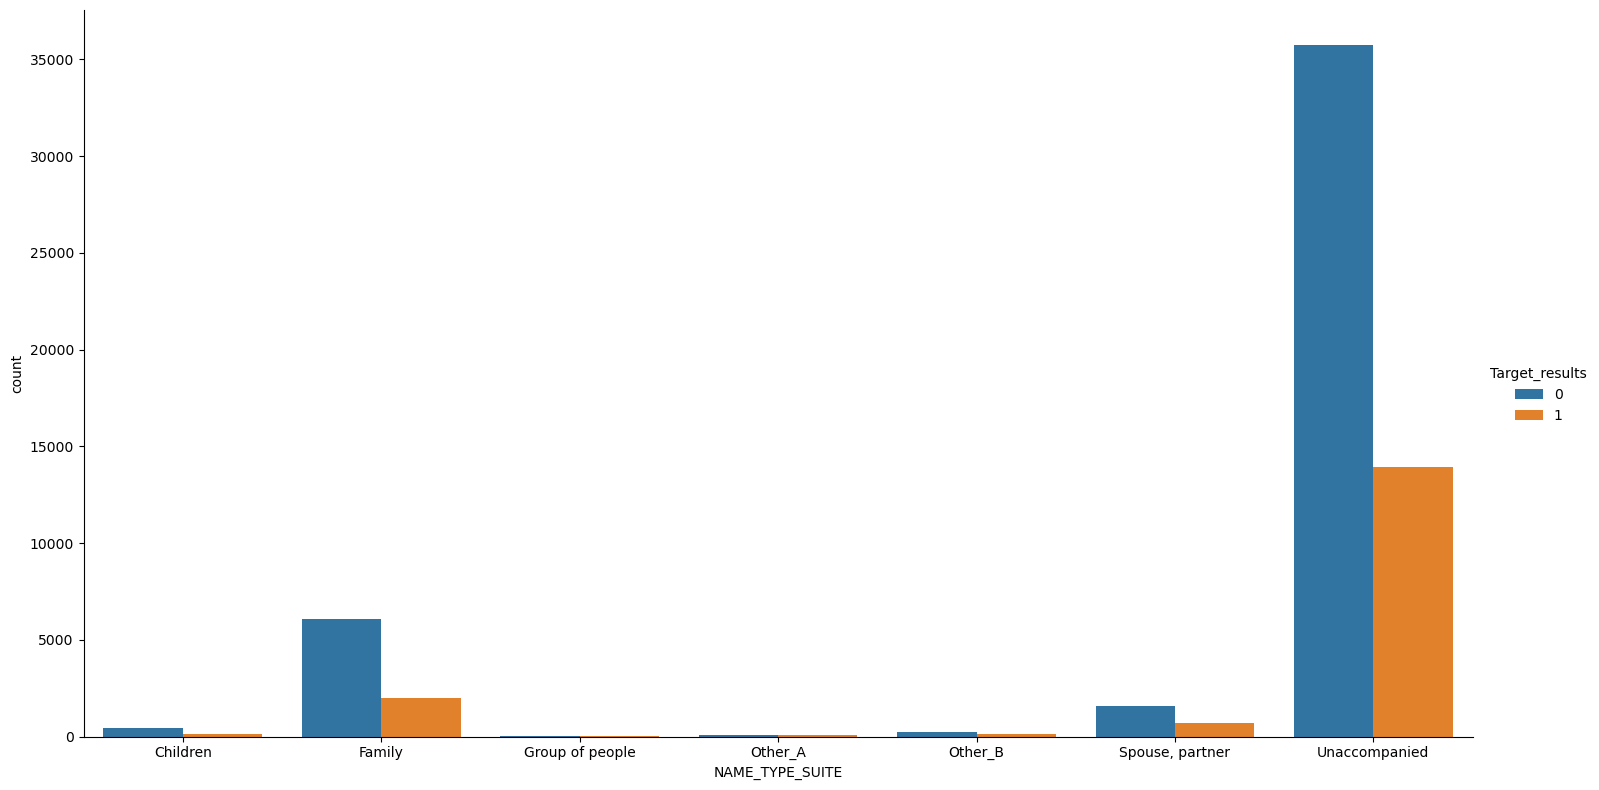

In [56]:
sns.catplot(x='NAME_TYPE_SUITE',hue='Target_results',data=test,kind="count", height=8, aspect=15/8)

### Income type

In [57]:
count_working = 0
count_commercial = 0
count_pensioner = 0
count_state = 0
count_unemp = 0
count_student = 0
count_business = 0
count_maternity = 0
for i in range(len(test)):
    if test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Working':
        count_working +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Commercial associate':
        count_commercial +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Pensioner':
        count_pensioner +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='State servant':
        count_state +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Unemployed':
        count_unemp +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Student':
        count_student +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Businessman':
        count_business +=1
    elif test.Target_results[i] == '1' and test.NAME_INCOME_TYPE[i]=='Maternity leave':
        count_maternity +=1
print(f"Working with target = 1: {count_working} \nCommercial associate with target = 1: {count_commercial} \nPensioner with target = 1: {count_pensioner} \nState servant with target = 1: {count_state} \nUnemployed with target = 1: {count_unemp} \nStudent with target = 1: {count_student} \nBusinessman with target = 1: {count_business} \nMaternity leave with target = 1: {count_maternity}")

Working with target = 1: 11137 
Commercial associate with target = 1: 3531 
Pensioner with target = 1: 1513 
State servant with target = 1: 851 
Unemployed with target = 1: 2 
Student with target = 1: 1 
Businessman with target = 1: 0 
Maternity leave with target = 1: 1


%

In [58]:
print(f"Working with target = 1: {(11137/31729)*100} \nCommercial associate with target = 1: {(3531/143447)*100} \nPensioner with target = 1: {(1513/11228)*100} \nState servant with target = 1: {(851/4185)*100} \nUnemployed with target = 1: {(2/5)*100} \nMaternity leave with target = 1: {(1/2)*100}")

Working with target = 1: 35.10038135459674 
Commercial associate with target = 1: 2.4615363165489694 
Pensioner with target = 1: 13.475240470252938 
State servant with target = 1: 20.33452807646356 
Unemployed with target = 1: 40.0 
Maternity leave with target = 1: 50.0


BEFORE

Working with target = 1: 9.588471664126368 

Commercial associate with target = 1: 7.484256531270509 

Pensioner with target = 1: 5.386366099490625 

State servant with target = 1: 5.754964751416855 

Unemployed with target = 1: 36.36363636363637 

Maternity leave with target = 1: 40.0

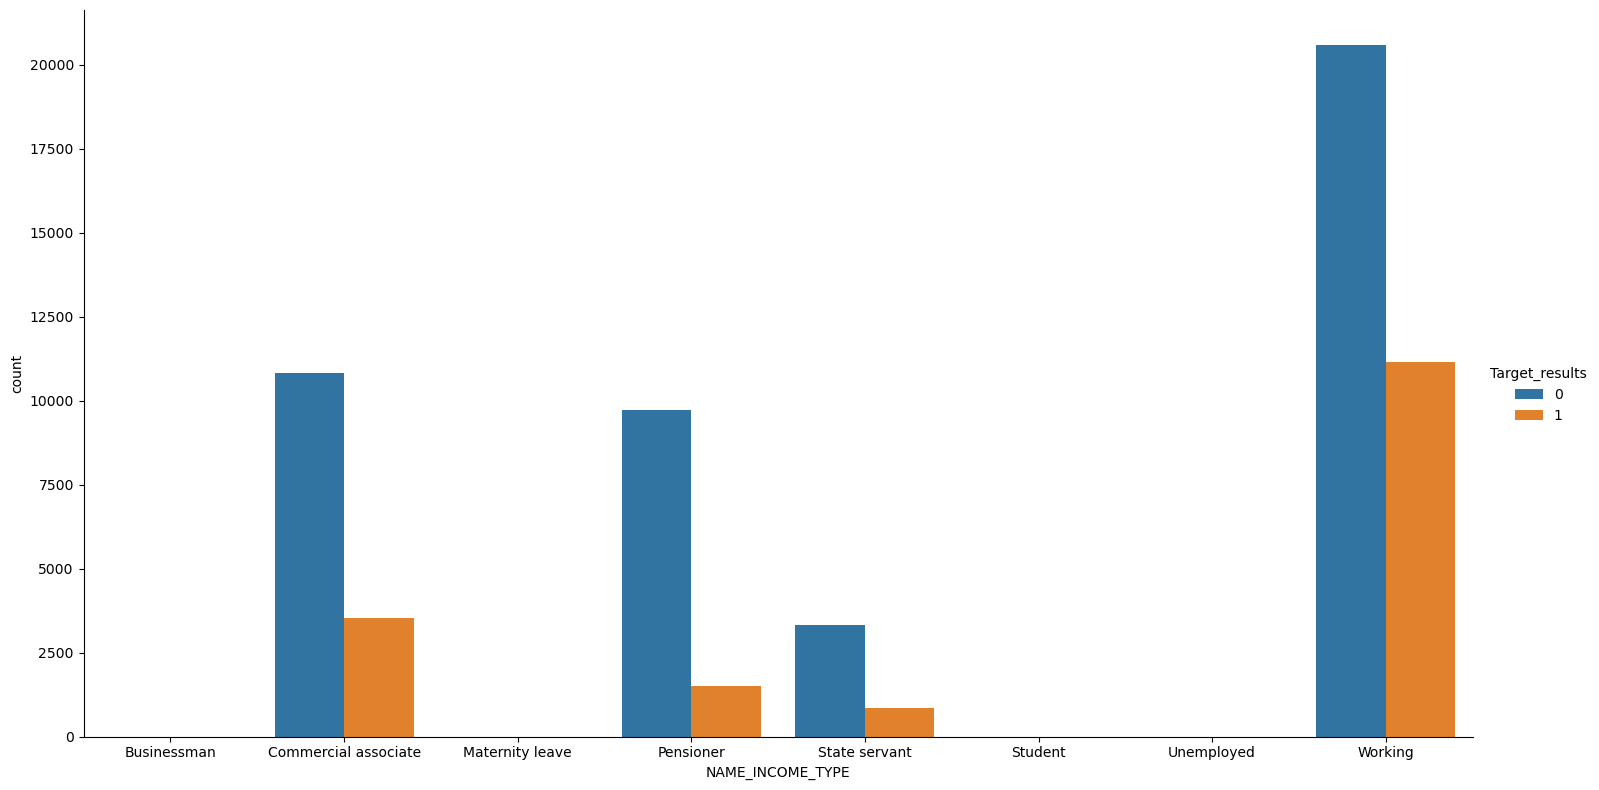

In [59]:
sns.catplot(x='NAME_INCOME_TYPE',hue='Target_results',data=test,kind="count", height=8, aspect=15/8)

### Education Type

In [60]:
count_secondary = 0
count_higher = 0
count_spouse = 0
count_lower = 0
count_academic = 0

for i in range(len(test)):
    if test.Target_results[i] == '1' and test.NAME_EDUCATION_TYPE[i]=='Secondary / secondary special':
        count_secondary +=1
    elif test.Target_results[i] == '1' and test.NAME_EDUCATION_TYPE[i]=='Higher education':
        count_higher +=1
    elif test.Target_results[i] == '1' and test.NAME_EDUCATION_TYPE[i]=='Incomplete higher':
        count_spouse +=1
    elif test.Target_results[i] == '1' and test.NAME_EDUCATION_TYPE[i]=='Lower secondary':
        count_lower +=1
    elif test.Target_results[i] == '1' and test.NAME_EDUCATION_TYPE[i]=='Academic degree':
        count_academic +=1

print(f"Secondary / secondary special with target = 1: {count_secondary} \nHigher education with target = 1: {count_higher} \nIncomplete higher with target = 1: {count_spouse} \nLower secondary with target = 1: {count_lower} \nAcademic degree with target = 1: {count_academic}")

Secondary / secondary special with target = 1: 13881 
Higher education with target = 1: 2271 
Incomplete higher with target = 1: 586 
Lower secondary with target = 1: 294 
Academic degree with target = 1: 4


In [61]:
print(f"Secondary / secondary special with target = 1: {(13881/43622)*100} \nHigher education with target = 1: {(2271/15060)*100} \nIncomplete higher with target = 1: {(586/1988)*100} \nLower secondary with target = 1: {(294/791)*100} \nAcademic degree with target = 1: {(4/40)*100}")

Secondary / secondary special with target = 1: 31.821099445234058 
Higher education with target = 1: 15.079681274900397 
Incomplete higher with target = 1: 29.47686116700201 
Lower secondary with target = 1: 37.16814159292036 
Academic degree with target = 1: 10.0


BEFORE

Secondary / secondary special with target = 1: 8.939928843221562 

Higher education with target = 1: 5.355115344028425 

Incomplete higher with target = 1: 8.484966429891992 

Lower secondary with target = 1: 10.927672955974844 

Academic degree with target = 1: 1.8292682926829267

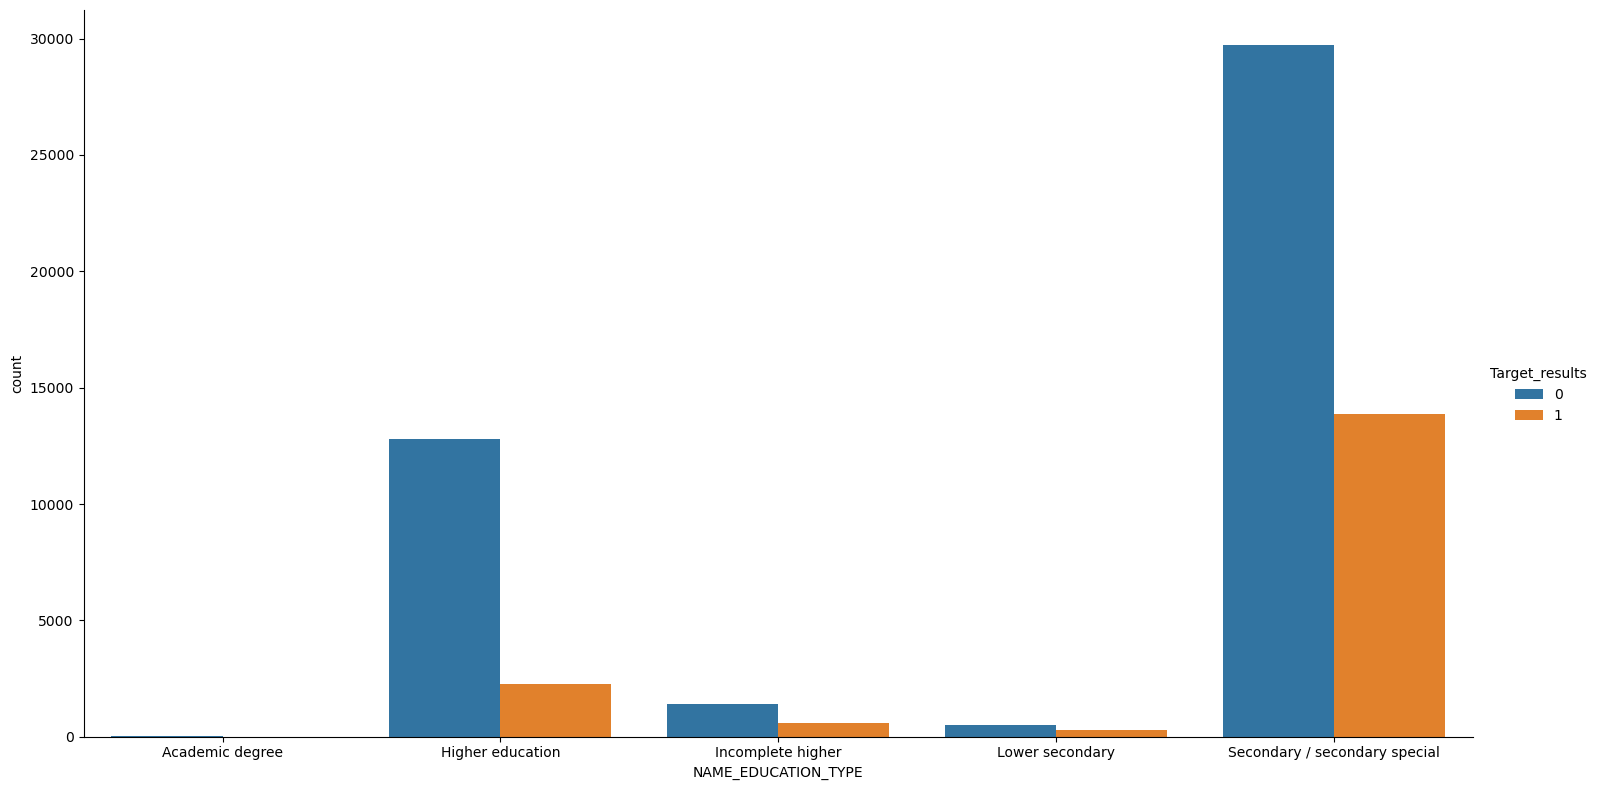

In [62]:
sns.catplot(x='NAME_EDUCATION_TYPE',hue='Target_results',data=test,kind="count", height=8, aspect=15/8)

# **[#5] Comparison of a few cases, changing just 1 or 2 features**

change the observations in the train set

In [2]:
train_altered = pd.read_csv('application_train.csv',
                usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])

In [3]:
train_altered['AGE'] = -round(train_altered['DAYS_BIRTH']/365)
train_altered.drop(columns='DAYS_BIRTH', inplace=True)
train_altered['CODE_GENDER_M'] = np.select([train_altered['CODE_GENDER'] == 'M', train_altered['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
train_altered['FLAG_OWN_CAR'] = np.where(train_altered['FLAG_OWN_CAR'] == 'Y', 1, 0)
train_altered['FLAG_OWN_REALTY'] = np.where(train_altered['FLAG_OWN_REALTY'] == 'Y', 1, 0)
train_altered.drop(columns='CODE_GENDER', inplace=True)
ap_objects = list(train_altered.select_dtypes(include=['object']).columns)
train_altered[ap_objects] = train_altered[ap_objects].astype('category')

In [4]:
train_altered['CODE_GENDER_M'] = np.where(train_altered['CODE_GENDER_M'] == 1.0, 0.0, 1.0)
train_altered['NAME_EDUCATION_TYPE'] = np.random.permutation(train_altered.NAME_EDUCATION_TYPE)
train_altered['NAME_INCOME_TYPE'] = np.random.permutation(train_altered.NAME_INCOME_TYPE)
train_altered['NAME_TYPE_SUITE'] = np.random.permutation(train_altered.NAME_TYPE_SUITE)
train_altered['NAME_FAMILY_STATUS'] = np.random.permutation(train_altered.NAME_FAMILY_STATUS)
train_altered['NAME_HOUSING_TYPE'] = np.random.permutation(train_altered.NAME_HOUSING_TYPE)
train_altered['OCCUPATION_TYPE'] = np.random.permutation(train_altered.OCCUPATION_TYPE)

In [5]:
train_altered['REGION_POPULATION_RELATIVE'] = train_altered['REGION_POPULATION_RELATIVE']*0.2 
train_altered['DAYS_EMPLOYED'] = train_altered['DAYS_EMPLOYED']*0.3
train_altered['AGE'] = train_altered['AGE']*0.2

train again the model on those data

In [156]:
ap_objects = list(train_altered.select_dtypes(include=['object']).columns)
train_altered[ap_objects] = train_altered[ap_objects].astype('category')

In [157]:
train_altered_target = train_altered.pop('TARGET')
print(f"Target dataset shape: {train_altered_target.shape}")

Target dataset shape: (307511,)


In [158]:
df_train1, df_test1, df_target_train1, df_target_test1 = train_test_split(
    train_altered, train_altered_target, test_size=0.2, stratify=train_altered_target, random_state=42)

print(f"Train dataset shape: {df_train1.shape}")
print(f"Test dataset shape: {df_test1.shape}")

Train dataset shape: (246008, 25)
Test dataset shape: (61503, 25)


In [159]:
df_train_dmatrix1 = xgb.DMatrix(df_train1.drop(columns='SK_ID_CURR'), df_target_train1, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model1 = xgb.train(param, df_train_dmatrix1, num_boost_round=50)

In [160]:
df_test_dmatrix1 = xgb.DMatrix(df_test1.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results1 = xgb_base_model1.predict(df_test_dmatrix1)

In [161]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test1, xgb_base_test_results1, pos_label=1)
metrics.auc(fpr, tpr)

0.750027626260829

from the original test

In [162]:
results = xgb_base_test_results.tolist()

In [163]:
#results = xgb_base_test_results.tolist()
df_test['results'] = results

In [186]:

df_test_altered = df_test.copy()
#df_test_altered['results'] = reults


I'll take a 5 random observations and alter the ethical variables

In [187]:
mini = df_test_altered.loc[[191493, 175463, 22506, 130105, 172854]]
mini

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,CODE_GENDER_M,results
191493,322041,Cash loans,0,0,0,90000.0,364896.0,19926.0,315000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.007330,-4930,-4654.0,-1259,NaN,Laborers,0.593554,0.619621,0.484851,49.0,0.0,0.295304
175463,303323,Cash loans,0,1,1,315000.0,545040.0,26509.5,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018801,-583,-6301.0,-931,NaN,Laborers,NaN,0.323326,0.047601,33.0,0.0,0.925040
22506,126190,Cash loans,0,0,0,126000.0,521280.0,28408.5,450000.0,Unaccompanied,Pensioner,Higher education,Single / not married,House / apartment,0.030755,0,-10462.0,-4055,NaN,NaN,NaN,0.160405,0.738020,65.0,0.0,0.462637
130105,250898,Cash loans,1,1,0,72000.0,990000.0,28944.0,990000.0,Unaccompanied,Working,Lower secondary,Married,House / apartment,0.007274,-4665,-2412.0,-4390,7.0,Drivers,NaN,0.207159,0.754406,42.0,1.0,0.189093
172854,300307,Cash loans,0,0,0,225000.0,1540305.0,42484.5,1206000.0,"Spouse, partner",Working,Secondary / secondary special,Civil marriage,House / apartment,0.008068,-1019,-19.0,-3323,NaN,NaN,0.281077,0.402770,0.353988,31.0,1.0,0.617748


original results = 0.295304, 0.92504, 0.462637, 0.189093, 0.617748

results with altered train set = 0.340106,  0.920172, 0.422609, 0.231705, 0.598979

In [188]:
mini.at[191493,'CNT_CHILDREN']= 2
mini.at[191493,'NAME_TYPE_SUITE']= 'Unaccompanied'
mini.at[191493,'NAME_INCOME_TYPE'] = 'State servant'
mini.at[191493, 'NAME_EDUCATION_TYPE'] = 'Incomplete higher'
mini.at[191493, 'NAME_FAMILY_STATUS'] = 'Single / not married'
mini.at[191493,'REGION_POPULATION_RELATIVE'] =  0.046220
mini.at[191493, 'DAYS_EMPLOYED'] = 1000
mini.at[191493, 'OCCUPATION_TYPE'] = 'Managers'
mini.at[191493, 'AGE'] = 67.0
mini.at[191493, 'CODE_GENDER_M'] = 1.0
mini.at[191493,'NAME_HOUSING_TYPE'] =  'Municipal apartment'

In [189]:
mini.at[175463,'CNT_CHILDREN']= 6
mini.at[175463,'NAME_TYPE_SUITE']= 'Family'
mini.at[175463,'NAME_INCOME_TYPE'] = 'Commercial associate'
mini.at[175463, 'NAME_EDUCATION_TYPE'] = 'Incomplete higher'
mini.at[175463,'NAME_HOUSING_TYPE'] = 'With parents'
mini.at[175463, 'NAME_FAMILY_STATUS'] = 'Single / not married'
mini.at[175463,'REGION_POPULATION_RELATIVE'] =  0.006220
mini.at[175463, 'DAYS_EMPLOYED'] = 5000
mini.at[175463, 'OCCUPATION_TYPE'] = 'Managers'
mini.at[175463, 'AGE'] = 50.0
mini.at[175463, 'CODE_GENDER_M'] = 1.0

In [190]:
mini.at[22506,'CNT_CHILDREN']= 4
mini.at[22506,'NAME_TYPE_SUITE']= 'Spouse, partner'
mini.at[22506,'NAME_INCOME_TYPE'] = 'Working'
mini.at[22506, 'NAME_EDUCATION_TYPE'] = 'Secondary / secondary special'
mini.at[22506,'NAME_HOUSING_TYPE'] = 'With parents'
mini.at[22506, 'NAME_FAMILY_STATUS'] = 'Married'
mini.at[22506,'REGION_POPULATION_RELATIVE'] =  0.016220
mini.at[22506, 'DAYS_EMPLOYED'] = 500
mini.at[22506, 'OCCUPATION_TYPE'] = 'Laborers'
mini.at[22506, 'AGE'] = 33.0
mini.at[22506, 'CODE_GENDER_M'] = 1.0

In [191]:
mini.at[130105,'CNT_CHILDREN']= 0
mini.at[130105,'NAME_TYPE_SUITE']= 'Family'
mini.at[130105,'NAME_INCOME_TYPE'] = 'State servant'
mini.at[130105, 'NAME_EDUCATION_TYPE'] = 'Higher education'
mini.at[130105,'NAME_HOUSING_TYPE'] = 'House / apartment'
mini.at[130105, 'NAME_FAMILY_STATUS'] = 'Single / not married'
mini.at[130105,'REGION_POPULATION_RELATIVE'] =  0.116220
mini.at[130105, 'DAYS_EMPLOYED'] = 6000
mini.at[130105, 'OCCUPATION_TYPE'] = 'Accountants'
mini.at[130105, 'AGE'] = 69.0
mini.at[130105, 'CODE_GENDER_M'] = 0.0

In [192]:
mini.at[172854,'CNT_CHILDREN']= 3
mini.at[172854,'NAME_TYPE_SUITE']= 'Unaccompanied'
mini.at[172854,'NAME_INCOME_TYPE'] = 'Maternity leave'
mini.at[172854, 'NAME_EDUCATION_TYPE'] = 'Incomplete higher'
mini.at[172854,'NAME_HOUSING_TYPE'] = 'House / apartment'
mini.at[172854, 'NAME_FAMILY_STATUS'] = 'Married'
mini.at[172854,'REGION_POPULATION_RELATIVE'] =  0.126220
mini.at[172854, 'DAYS_EMPLOYED'] = 6000
mini.at[172854, 'OCCUPATION_TYPE'] = 'Laborers'
mini.at[172854, 'AGE'] = 70.0
mini.at[172854, 'CODE_GENDER_M'] = 0.0

fit the model

In [193]:
mini = mini.drop('results', axis = 1)

In [194]:
mini_model = xgb.DMatrix(mini.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results_mini = xgb_base_model.predict(mini_model)

In [195]:
xgb_base_test_results_mini

array([0.42982402, 0.9457106 , 0.76833373, 0.1644406 , 0.41144636],
      dtype=float32)

original results = 0.295304, 0.92504, 0.462637, 0.189093, 0.617748

# **[#8] A closer look at the performance without features of ethical concern**

In [36]:
ap_train3 = pd.read_csv('application_train.csv',
                    usecols=  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE',
                                'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'])

In [37]:
ap_train3['FLAG_OWN_CAR'] = np.where(ap_train3['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train3['FLAG_OWN_REALTY'] = np.where(ap_train3['FLAG_OWN_REALTY'] == 'Y', 1, 0)

In [38]:
ap_objects = list(ap_train3.select_dtypes(include=['object']).columns)
ap_train3[ap_objects] = ap_train3[ap_objects].astype('category')

In [39]:
ap_train_target3 = ap_train3.pop('TARGET')
print(f"Target dataset shape: {ap_train_target3.shape}")

Target dataset shape: (307511,)


In [40]:
df_train3, df_test3, df_target_train3, df_target_test3 = train_test_split(
    ap_train3, ap_train_target3, test_size=0.2, stratify=ap_train_target3, random_state=42)

print(f"Train dataset shape: {df_train3.shape}")
print(f"Test dataset shape: {df_test3.shape}")

Train dataset shape: (246008, 10)
Test dataset shape: (61503, 10)


In [41]:
df_train_dmatrix3 = xgb.DMatrix(df_train3.drop(columns='SK_ID_CURR'), df_target_train3, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model3 = xgb.train(param, df_train_dmatrix3, num_boost_round=50)

In [42]:
df_test_dmatrix3 = xgb.DMatrix(df_test3.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results3 = xgb_base_model3.predict(df_test_dmatrix3)

In [43]:
xgb_base_test_results3[:5]

array([0.3147233 , 0.6352069 , 0.5236772 , 0.49664757, 0.5131301 ],
      dtype=float32)

In [44]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(df_target_test3, xgb_base_test_results3, pos_label=1)
metrics.auc(fpr, tpr)

0.7534904346699134

In [45]:
#plot the ROC curve
fig = px.line(x=fpr1, y=tpr1, title='ROC Curve', width=500,height=500,)
fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1, line=dict(color="Red", dash="dash"))

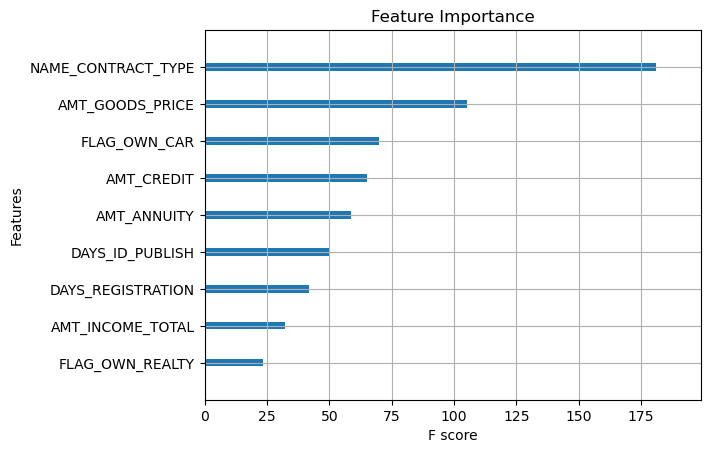

In [206]:
#plot feature importance
xgb.plot_importance(xgb_base_model3, importance_type='gain', max_num_features=10, show_values=False, title='Feature Importance')
plt.show()


### Check on the individual cases

In [207]:
mini2 = df_test3.loc[[191493, 175463, 22506, 130105, 172854]]

In [208]:
mini_model2 = xgb.DMatrix(mini2.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results_mini2 = xgb_base_model3.predict(mini_model2)

In [209]:
xgb_base_test_results_mini2

array([0.6352069, 0.6166435, 0.5886503, 0.2598523, 0.3836534],
      dtype=float32)

original results = 0.295304, 0.92504, 0.462637, 0.189093, 0.617748

results with altered ethic variables = 0.42982402, 0.9457106 , 0.76833373, 0.1644406 , 0.41144636

## SHAP 

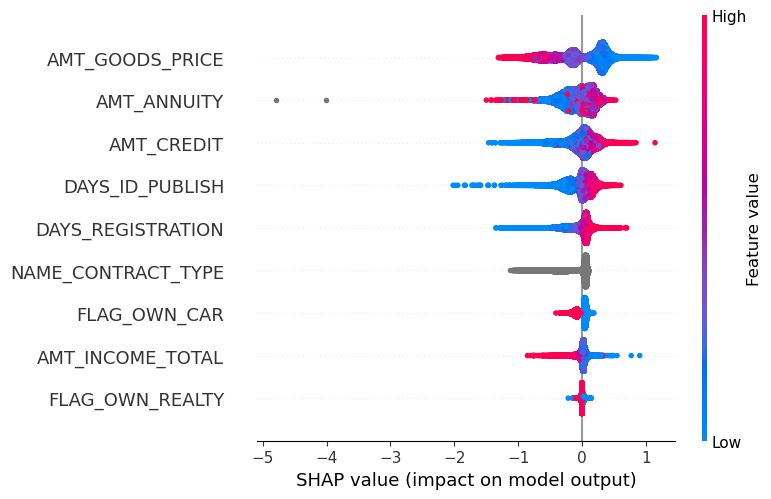

In [210]:
explainer = shap.TreeExplainer(xgb_base_model3)
shap_values = explainer.shap_values(df_test_dmatrix3)
shap.summary_plot(shap_values, df_test3.iloc[:,1:])

# **[#9] Wrapping up again: what happens by just removing the features of concern**

In [211]:
results = xgb_base_test_results.tolist()
df_test['results'] = results
results_unet = xgb_base_test_results3.tolist()
df_test['results_unet'] = results_unet
df_test.reset_index(inplace = True)

### Gender Analysis

In [212]:
 df_test.groupby('CODE_GENDER_M')['results','results_unet'].mean()

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\1941760613.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,results,results_unet
CODE_GENDER_M,,
0.0,0.349509,0.430417
1.0,0.431419,0.432498


### Age

In [213]:
 age = df_test.groupby('AGE')['results','results_unet'].mean()
 age

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\832585242.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,results,results_unet
AGE,,
21.0,0.512061,0.514985
22.0,0.524695,0.521563
23.0,0.527962,0.515763
24.0,0.488870,0.504990
25.0,0.452510,0.503074
26.0,0.444931,0.498638
27.0,0.473961,0.496501
28.0,0.473720,0.501111
29.0,0.466757,0.489994


<AxesSubplot:xlabel='results', ylabel='AGE'>

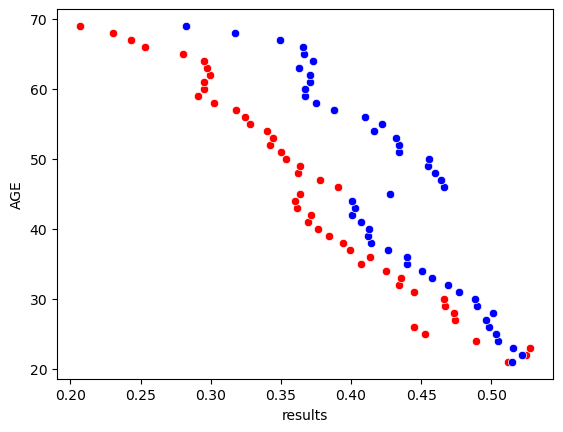

In [214]:
sns.scatterplot(data = age, x = age.results, y =age.index, c = 'r')
sns.scatterplot(data = age, x = age.results_unet, y =age.index, c = 'b')

### Region

In [215]:
region = df_test.groupby('REGION_POPULATION_RELATIVE')['results','results_unet'].mean()

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\3452031493.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [216]:
np.mean(region['results'])

0.39301939373436434

In [217]:
np.mean(region['results_unet'])

0.4387076757925194

By putting the region variable into the model, the porbabily of doing defaul decreses

<AxesSubplot:xlabel='results', ylabel='REGION_POPULATION_RELATIVE'>

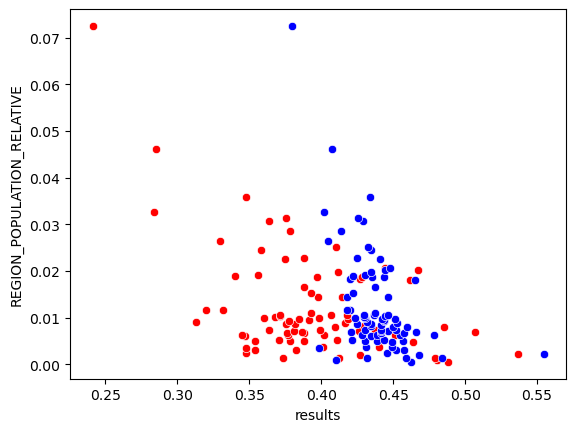

In [218]:
sns.scatterplot( x = region.results, y =region.index, c = 'r')
sns.scatterplot( x = region.results_unet, y =region.index, c = 'b')

### Family Status

In [219]:
family = df_test.groupby('NAME_FAMILY_STATUS')['results','results_unet'].mean()
family.drop('Unknown', axis = 0, inplace = True)
family

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\3575506682.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,results,results_unet
NAME_FAMILY_STATUS,,
Civil marriage,0.418235,0.448317
Married,0.367144,0.426389
Separated,0.371928,0.430948
Single / not married,0.415317,0.451438
Widow,0.326951,0.400167


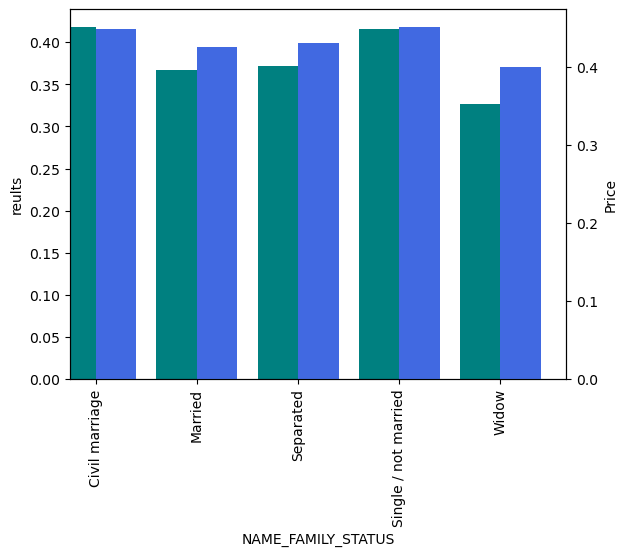

In [220]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

family.results.plot(kind='bar', color='teal', ax=ax, width=width, position=1)
family.results_unet.plot(kind='bar', color='royalblue', ax=ax2, width=width, position=0)

ax.set_ylabel('reults')
ax2.set_ylabel('Price')

plt.show()

### Education Type

In [221]:
education = df_test.groupby('NAME_EDUCATION_TYPE')['results','results_unet'].mean()
education

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\832094180.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,results,results_unet
NAME_EDUCATION_TYPE,,
Academic degree,0.204570,0.387774
Higher education,0.291850,0.409452
Incomplete higher,0.399391,0.460037
Lower secondary,0.430927,0.430779
Secondary / secondary special,0.405119,0.437333


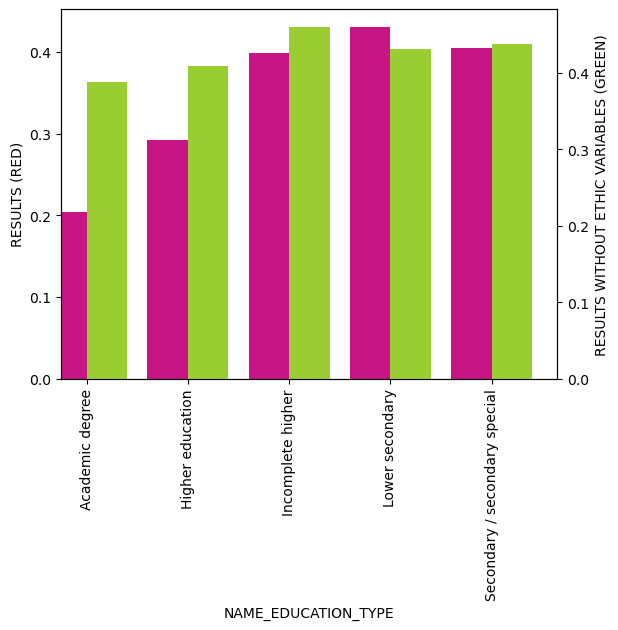

In [222]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

education.results.plot(kind='bar', color='mediumvioletred', ax=ax, width=width, position=1)
education.results_unet.plot(kind='bar', color='yellowgreen', ax=ax2, width=width, position=0)

ax.set_ylabel('RESULTS (RED)')
ax2.set_ylabel('RESULTS WITHOUT ETHIC VARIABLES (GREEN)')

plt.show()

As the title of education increases, without putting the variable in the model, the risk score increases

### Name type suite

In [223]:
suite = df_test.groupby('NAME_TYPE_SUITE')['results','results_unet'].mean()
suite

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\3778932593.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,results,results_unet
NAME_TYPE_SUITE,,
Children,0.355205,0.432084
Family,0.362838,0.424330
Group of people,0.346589,0.398424
Other_A,0.405280,0.450130
Other_B,0.394681,0.456138
"Spouse, partner",0.392457,0.436929
Unaccompanied,0.379473,0.431967


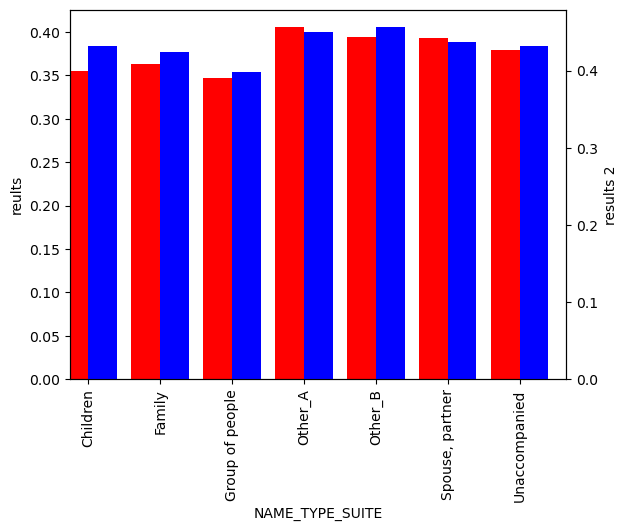

In [224]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

suite.results.plot(kind='bar', color='red', ax=ax, width=width, position=1)
suite.results_unet.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('reults')
ax2.set_ylabel('results 2')

plt.show()

### Days Employed

In [225]:
employment = df_test.groupby('DAYS_EMPLOYED')['results','results_unet'].mean()

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\2484798312.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [226]:
np.mean(employment['results'])

0.3280529234788594

In [227]:
np.mean(employment['results_unet'])

0.42345797538501967

# Check for variations in the results

In [228]:
graph = df_test[:50]
graph['diff'] = graph['results_unet'] - graph['results']
graph['positive'] = np.where(graph['diff'] >= 0, True, False)

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\2630247524.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\osann\AppData\Local\Temp\ipykernel_15940\2630247524.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



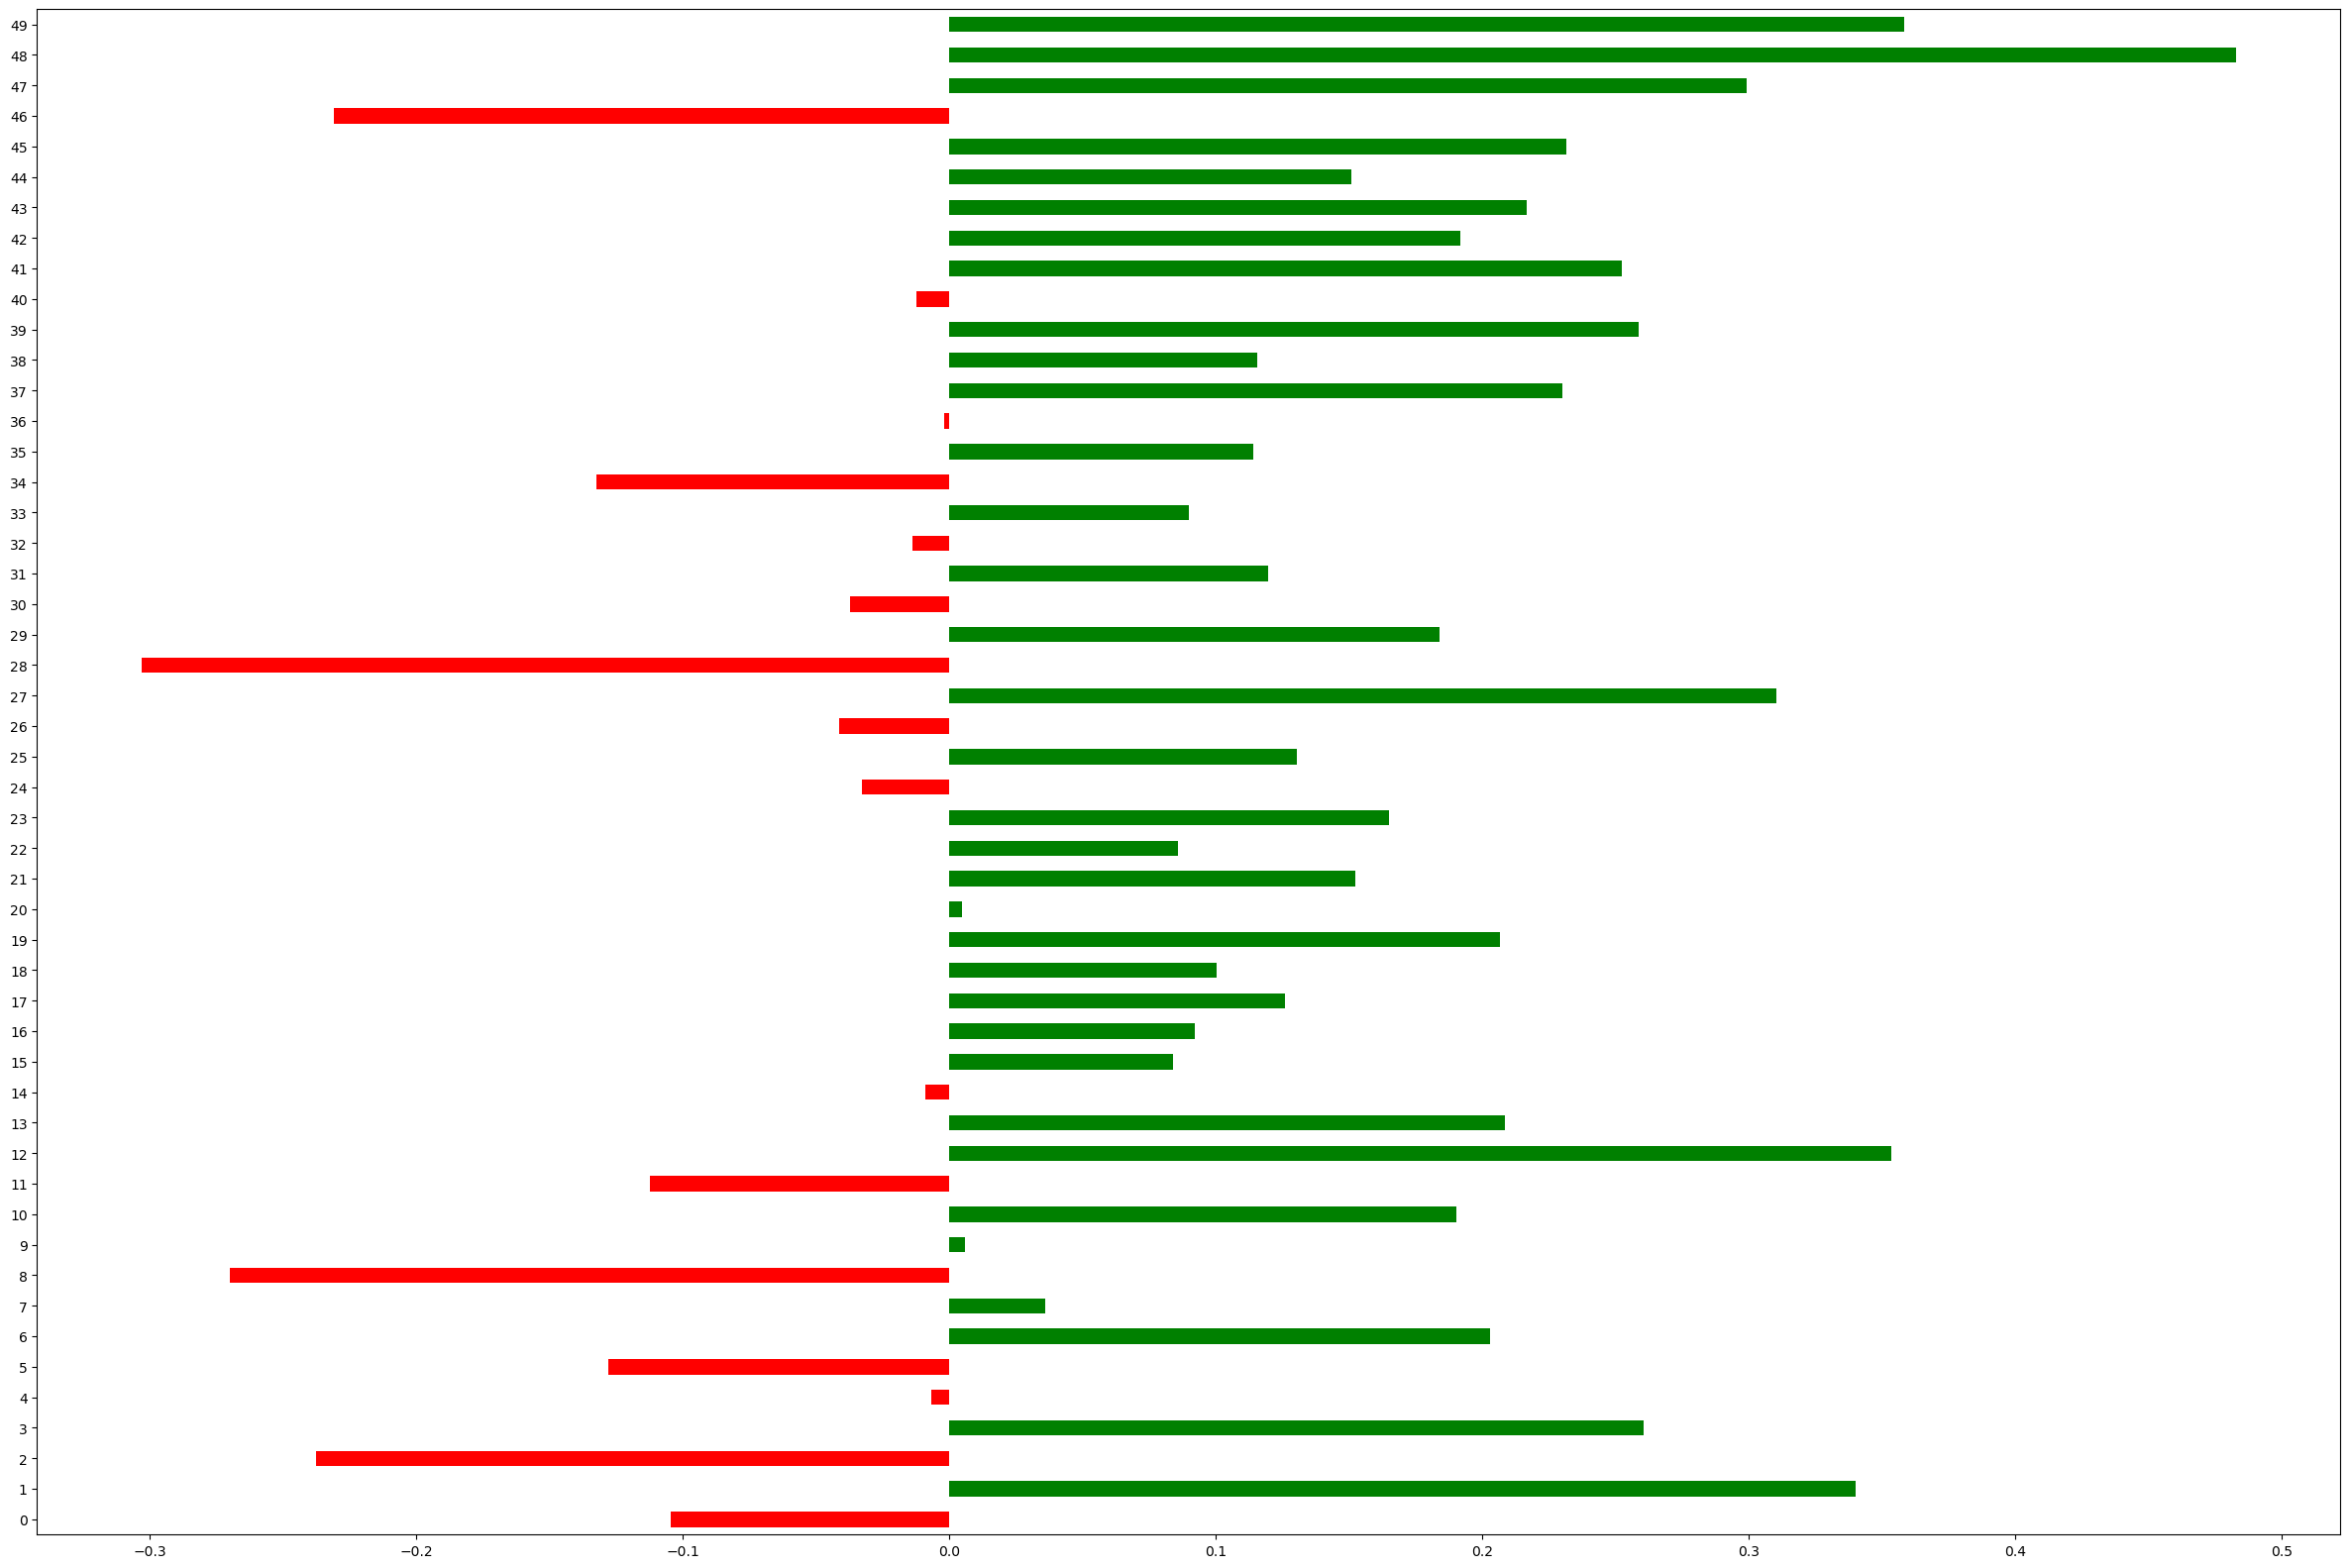

In [229]:
graph['diff'].plot(kind='barh', figsize=(30, 20),
                             color=graph.positive.map({True: 'g', False: 'r'}))
plt.show()

# **[#10] Hints at a possible (but questionable!) solution**